# 1 Dataset Exploration -  N-CMAPSS DS02

Nous allons travailler aujourd'hui avec une partie du dataset CMAPSS DS02 fourni par la NASA. Il donne les trajectoires de dégradation de 9 moteurs aux condition initiales inconnues et 2 modes de dégradation. 

Pour plus de détails sur le dataset complet : https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan-2

In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
### Set-up - Define file location
#from google.colab import drive
#drive.mount("/content/drive")

In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Maintenance_Predictive_TP_teacher/
%ls

[WinError 3] Le chemin d’accès spécifié est introuvable: '/content/drive/MyDrive/Colab\\ Notebooks/Maintenance_Predictive_TP_teacher/'
C:\Users\d559009\Desktop\Expertise\CoursDonnés\CoursENSTA\2022-2023\gitteacher\TPs
 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est 54D9-9F54

 R‚pertoire de C:\Users\d559009\Desktop\Expertise\CoursDonn‚s\CoursENSTA\2022-2023\gitteacher\TPs

17/01/2023  19:38    <DIR>          .
17/01/2023  19:38    <DIR>          ..
16/01/2023  10:57    <DIR>          .ipynb_checkpoints
17/01/2023  19:35    <DIR>          data
13/01/2023  13:39         3ÿ068ÿ404 kde_DS02.png
04/01/2023  11:02            88ÿ446 Maintenance_TP1_correction.ipynb
11/01/2023  11:48         1ÿ349ÿ493 Maintenance_TP2_correction.ipynb
11/01/2023  09:53             8ÿ913 Maintenance_TP2_student.ipynb
17/01/2023  19:34            15ÿ839 Maintenance_TP3_data_converter.ipynb
16/01/2023  11:00            17ÿ155 Maintenance_TP3_student.ipynb
17/01/2023  19:38         

In [4]:
filenames = ['N-CMAPSS_DS01-005.h5', 'N-CMAPSS_DS02-006.h5', 'N-CMAPSS_DS04.h5']
%ls

 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est 54D9-9F54

 R‚pertoire de C:\Users\d559009\Desktop\Expertise\CoursDonn‚s\CoursENSTA\2022-2023\gitteacher\TPs

17/01/2023  19:38    <DIR>          .
17/01/2023  19:38    <DIR>          ..
16/01/2023  10:57    <DIR>          .ipynb_checkpoints
17/01/2023  19:35    <DIR>          data
13/01/2023  13:39         3ÿ068ÿ404 kde_DS02.png
04/01/2023  11:02            88ÿ446 Maintenance_TP1_correction.ipynb
11/01/2023  11:48         1ÿ349ÿ493 Maintenance_TP2_correction.ipynb
11/01/2023  09:53             8ÿ913 Maintenance_TP2_student.ipynb
17/01/2023  19:34            15ÿ839 Maintenance_TP3_data_converter.ipynb
16/01/2023  11:00            17ÿ155 Maintenance_TP3_student.ipynb
17/01/2023  19:38         6ÿ685ÿ197 Maintenance_TP3_student_correction.ipynb
               7 fichier(s)       11ÿ233ÿ447 octets
               4 R‚p(s)  12ÿ562ÿ714ÿ624 octets libres


#### Read Raw Data

In [33]:
pd.__version__

'1.1.3'

In [5]:
# Load data
with pd.HDFStore('data/TP3_survival_data.h5', complevel=9, complib='zlib') as store:
    df_A = store['SurvivalMatrix']
df_W = []
df_T = []
df_X_s = []
for unit in df_A['unit'].unique():
    with pd.HDFStore('data/TP3_ext_cond_data' + str(unit) + '.h5', complevel=9, complib='zlib') as store:
        df_W.append(store['ExternalConditions'])
    with pd.HDFStore('data/TP3_health_data' + str(unit) + '.h5', complevel=9, complib='zlib') as store:
        df_T.append(store['HealthData'])
    with pd.HDFStore('data/TP3_sensors_data' + str(unit) + '.h5', complevel=9, complib='zlib') as store:
        df_X_s.append(store['SensorsData'])
        
df_W = pd.concat(df_W, ignore_index=True)
df_T = pd.concat(df_T, ignore_index=True)
df_X_s = pd.concat(df_X_s, ignore_index=True)

## Auxiliary Information ($A$)
Dans cette dataframe, vous aurez accès aux cycles, ainsi qu'au numéro du moteur, et l'état de santé.

In [6]:
print(df_A.describe())
print('Engine units IDs dans le dataframe: ', np.unique(df_A['unit']))

               unit         cycle            Fc            hs
count  2.413911e+06  2.413911e+06  2.413911e+06  2.413911e+06
mean   2.580149e+02  4.213013e+01  2.564383e+00  2.362457e-01
std    1.768949e+02  2.499476e+01  6.250828e-01  4.247749e-01
min    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00
25%    1.080000e+02  2.100000e+01  2.000000e+00  0.000000e+00
50%    2.180000e+02  4.100000e+01  3.000000e+00  0.000000e+00
75%    4.050000e+02  6.200000e+01  3.000000e+00  0.000000e+00
max    5.100000e+02  1.000000e+02  3.000000e+00  1.000000e+00
Engine units IDs dans le dataframe:  [  1.   2.   3.   4.   5.   6. 107. 108. 109. 110. 202. 205. 210. 216.
 218. 220. 311. 314. 315. 401. 402. 403. 404. 405. 406. 507. 508. 509.
 510.]


### End Of Failure ($t_{\text{EOF}}$)

1.1 Donnez le nombre de cycles auquel les moteurs sont envoyés en maintenance. Visualisez ces pannes dans le temps. Que pourriez-vous faire avec ces données ? (5'/5')

Unit: 1.0 - Number of flight cyles (t_{EOF}):  100
Unit: 2.0 - Number of flight cyles (t_{EOF}):  75
Unit: 3.0 - Number of flight cyles (t_{EOF}):  100
Unit: 4.0 - Number of flight cyles (t_{EOF}):  95
Unit: 5.0 - Number of flight cyles (t_{EOF}):  89
Unit: 6.0 - Number of flight cyles (t_{EOF}):  94
Unit: 107.0 - Number of flight cyles (t_{EOF}):  90
Unit: 108.0 - Number of flight cyles (t_{EOF}):  89
Unit: 109.0 - Number of flight cyles (t_{EOF}):  80
Unit: 110.0 - Number of flight cyles (t_{EOF}):  82
Unit: 202.0 - Number of flight cyles (t_{EOF}):  75
Unit: 205.0 - Number of flight cyles (t_{EOF}):  89
Unit: 210.0 - Number of flight cyles (t_{EOF}):  82
Unit: 216.0 - Number of flight cyles (t_{EOF}):  63
Unit: 218.0 - Number of flight cyles (t_{EOF}):  71
Unit: 220.0 - Number of flight cyles (t_{EOF}):  66
Unit: 311.0 - Number of flight cyles (t_{EOF}):  59
Unit: 314.0 - Number of flight cyles (t_{EOF}):  76
Unit: 315.0 - Number of flight cyles (t_{EOF}):  67
Unit: 401.0 - Number o

(0.0, 120.0)

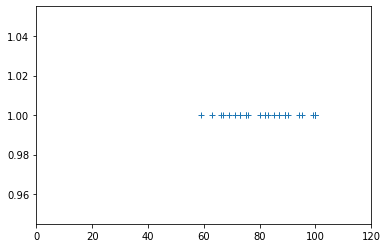

In [7]:
# Réponse
df_failures = pd.DataFrame()

fail = []
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_{EOF}): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    fail.append(len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))

df_failures['unit'] = np.unique(df_A['unit'])
df_failures['fail'] = fail

plt.plot(df_failures['fail'], np.ones(df_failures.shape[0]), '+')
plt.xlim(0, 120)

# Il est possible d'essayer de faire une analyse statistique de ces durées de vie.

1.2 Ajustez un modèle de weibull sur les données, affichez le résultat. (5'/10')

[8.055683] [87.8338984]


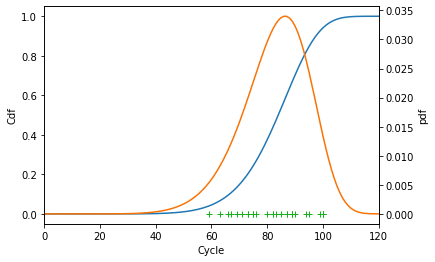

In [8]:
import scipy.optimize
equipement_life = df_failures['fail']
# réponse
def F(k):
    return np.sum((equipement_life**k)*np.log(equipement_life))/np.sum((equipement_life**k)) - 1/k - np.mean(np.log(equipement_life))
k_hat = scipy.optimize.broyden1(F, [3], f_tol=1e-5)

lambda_hat = np.mean(equipement_life**k_hat)**(1/k_hat)
print(k_hat, lambda_hat)

d = np.arange(0, 1.3*np.max(equipement_life))
survival = (k_hat/lambda_hat) * np.power((d/lambda_hat),(k_hat-1))*np.exp(-np.power((d/lambda_hat), k_hat))
cdf = 1-np.exp(-np.power(d/lambda_hat, k_hat))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_failures['fail'], np.zeros(df_failures.shape[0]), '+', color='xkcd:green')
ax1.plot(d, cdf)
ax2.plot(d, survival, color='xkcd:orange')

ax1.set_xlabel('Cycle')
ax1.set_ylabel('Cdf')
ax2.set_ylabel('pdf')

plt.xlim(0, 120);

## Operative Conditions ($w$)

Le dataframe df_W contient des données d'environnement : l'altitude et le Mach.
Ces données ont été récupérées ici : https://c3.nasa.gov/dashlink/

1.3. Affichez les variables de la matrice W pour un vol au choix, puis affichez toutes les altitudes de tous les vols d'une même unité sur un même graphique. Quelle astuce pouvez-vous utiliser pour rendre la figure plus lisible ? (10'/20')

107.0 3
108.0 3
109.0 3
110.0 3
202.0 3


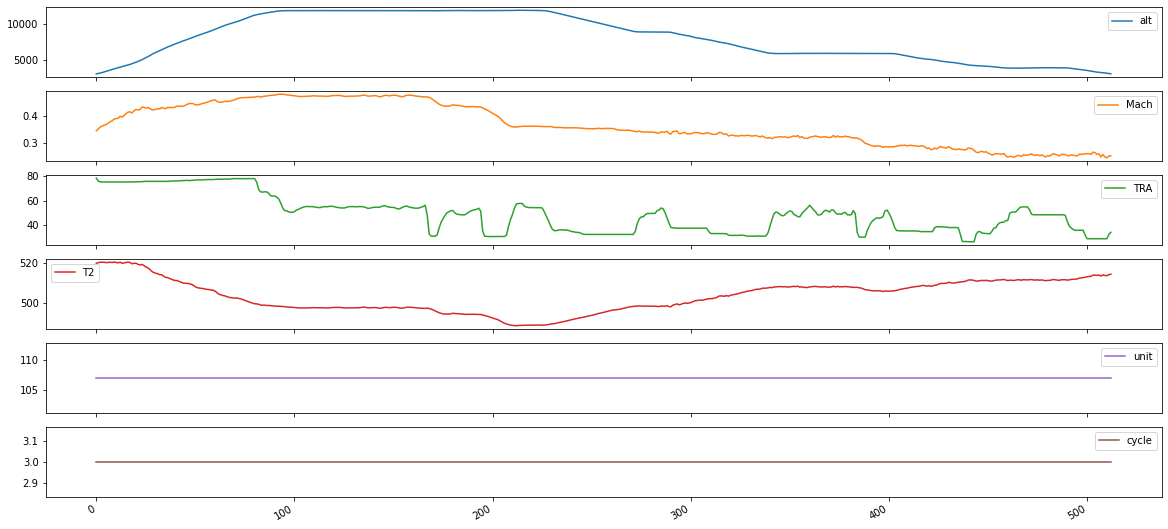

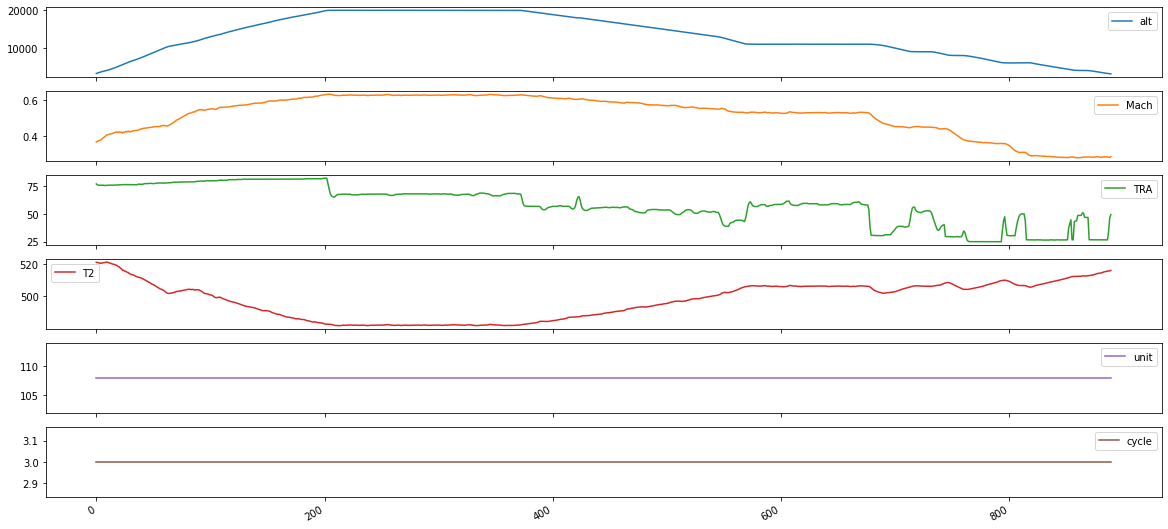

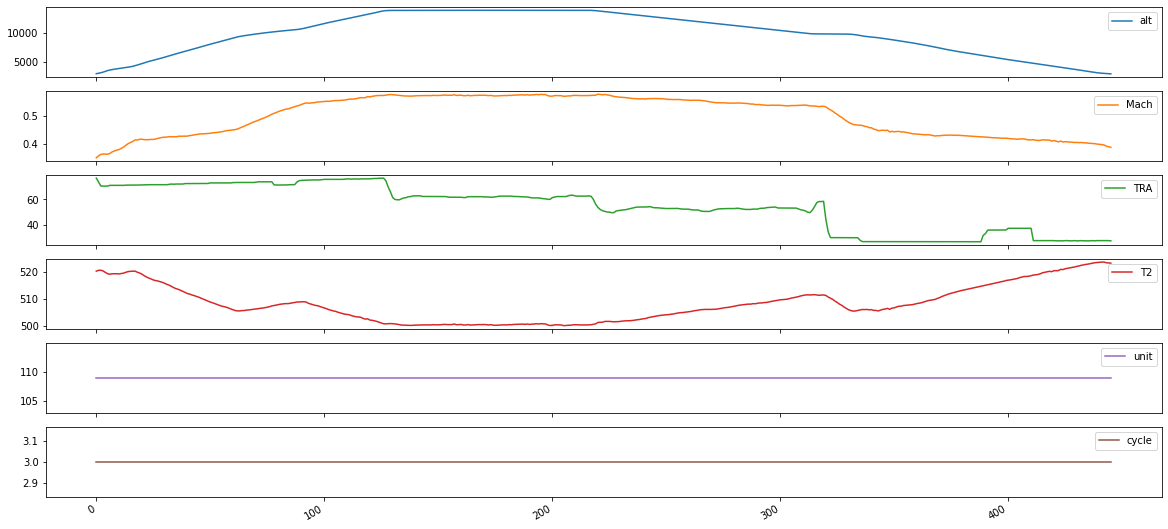

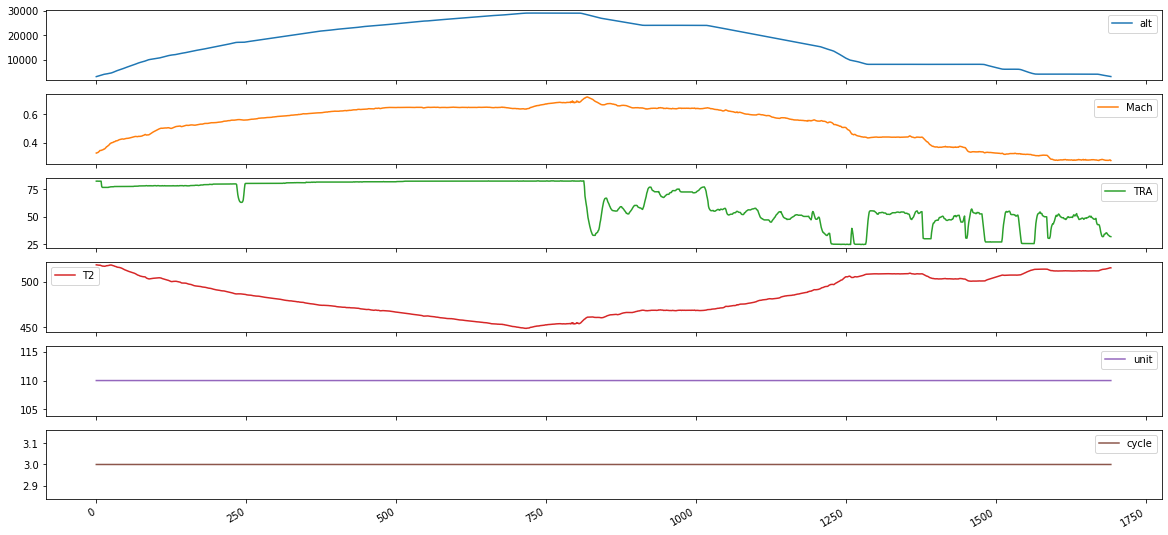

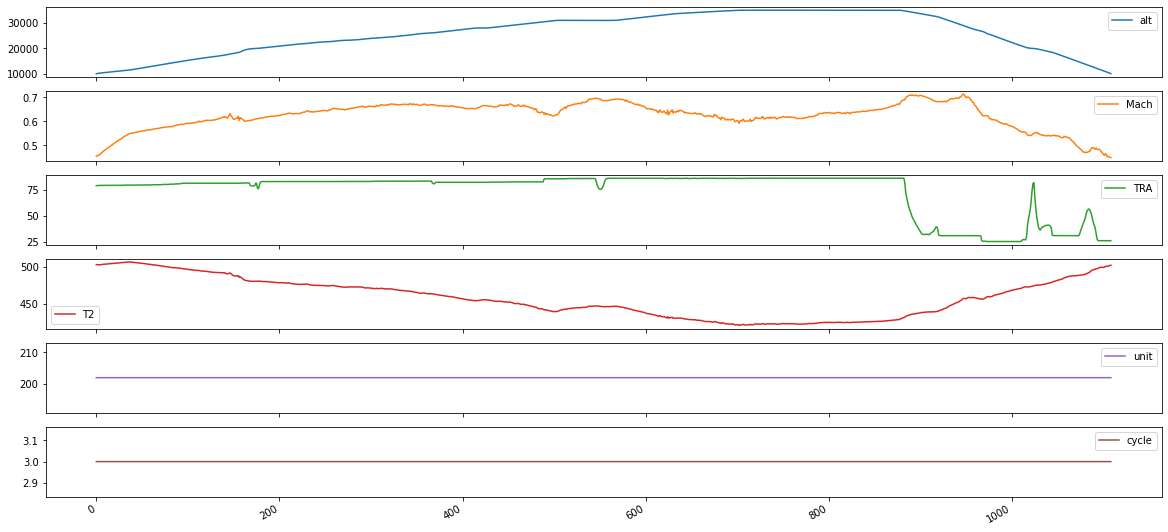

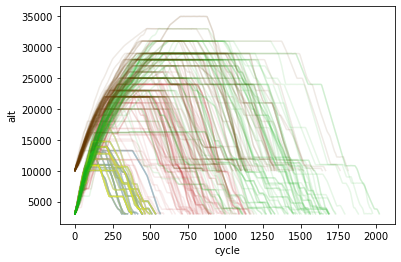

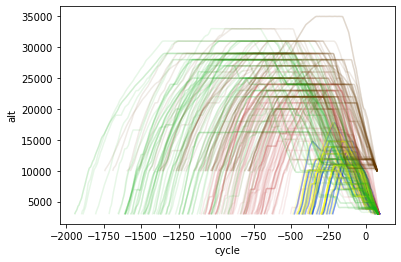

In [9]:
# Réponse
c = {}
c[0] = 'xkcd:blue'
c[1] = 'xkcd:reddish'
c[2] = 'xkcd:yellow'
c[3] = 'xkcd:green'
c[4] = 'xkcd:brown'
c[5] = 'xkcd:black'

for ids, selected_unit in enumerate(df_A['unit'].unique()[6:11]):
    selected_cycle = 3
    print(selected_unit, selected_cycle)

    df_W_u = df_W.loc[(df_A.unit == selected_unit) & (df_A.cycle == selected_cycle)]
    df_W_u.reset_index(inplace=True, drop=True)
    df_W_u.plot(subplots=True, figsize=(20, 10))

    df_W_u = df_W.loc[(df_A.unit == selected_unit)].copy()
    df_W_u['cycle'] = df_A['cycle'].loc[(df_A.unit==selected_unit)]
    df_W_u.reset_index(inplace=True, drop=True)
    plt.figure(2)
    cycle_sel  = np.unique(df_W_u['cycle'])
    for j in cycle_sel:
        data_cycle = df_W_u.loc[df_W_u['cycle'] == j]
        time_s = np.arange(len(data_cycle))
        plt.plot(time_s, data_cycle['alt'], alpha=0.1, color=c[ids])
        plt.xlabel('cycle')
        plt.ylabel('alt')

    plt.figure(3)
    cycle_sel  = np.unique(df_W_u['cycle'])
    for j in cycle_sel:
        data_cycle = df_W_u.loc[df_W_u['cycle'] == j]
        time_s = np.arange(np.max(cycle_sel) - len(data_cycle), np.max(cycle_sel))
        plt.plot(time_s, data_cycle['alt'], alpha=0.1, color=c[ids])
        plt.xlabel('cycle')
        plt.ylabel('alt')
    

### Conditions de vol

1.4. Tracer les densités des conditions d'utilisation pour chaque unité. (10'/30')

In [10]:
# Réponse
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit '+str(int(unit_id)):'C'+str(int(unit_id)) for unit_id in df_A['unit'].unique()} 

    fig = plt.figure(figsize=(size, max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 432x288 with 0 Axes>

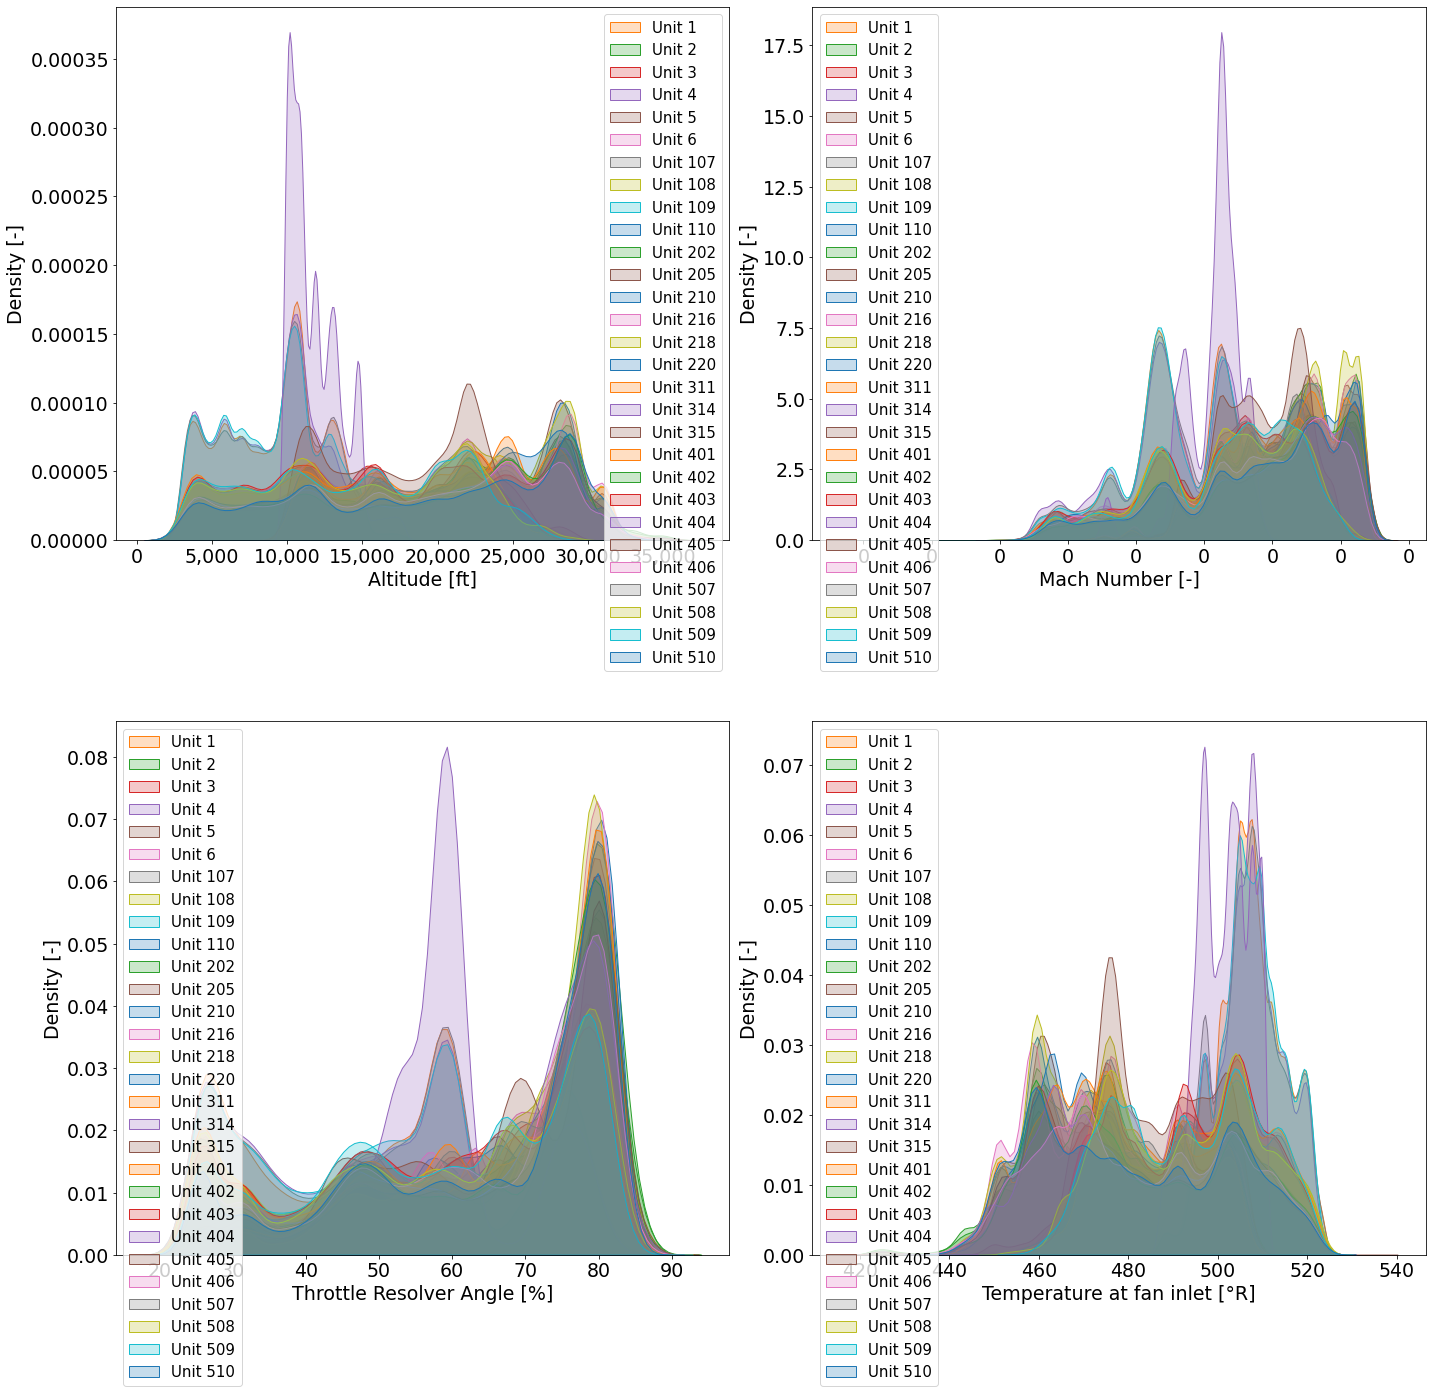

In [11]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 20

units = list(np.unique(df_A['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=19)

1.5 Visualiser la densité des conditions d'utilisation dans le temps. Que pouvez-vous en déduire ? (5'/35')

<ipython-input-12-d903bc26b0d9>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 5))


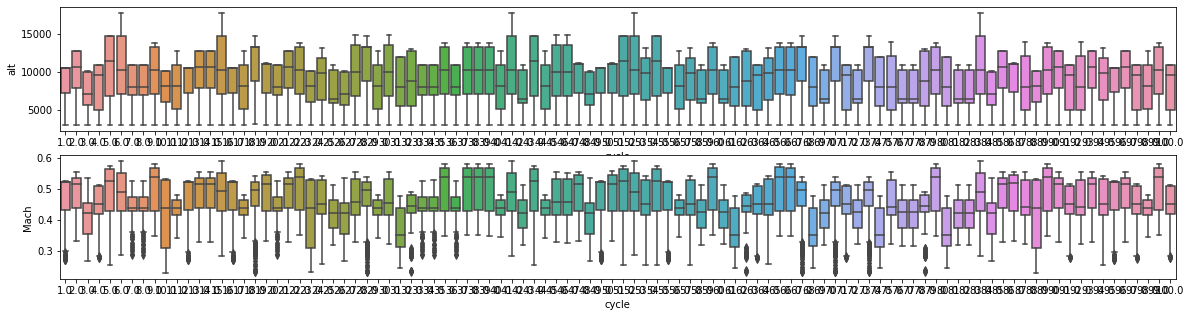

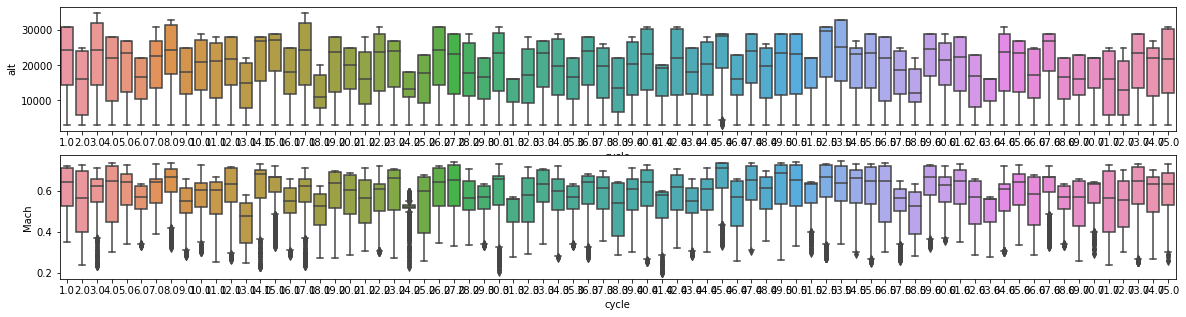

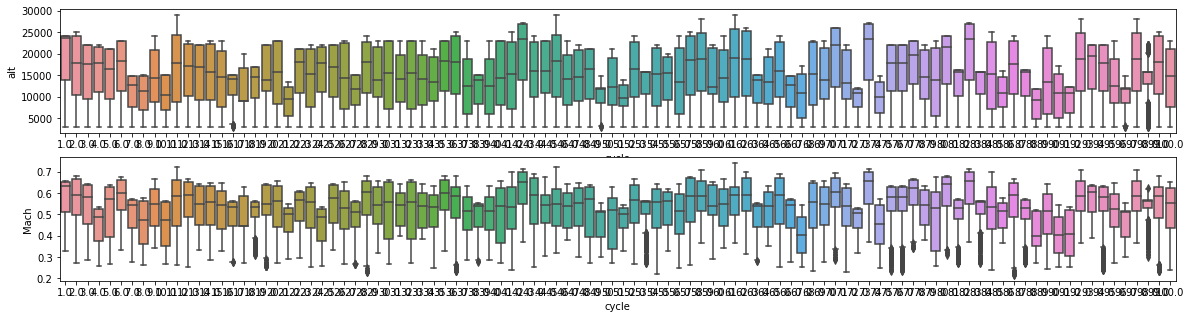

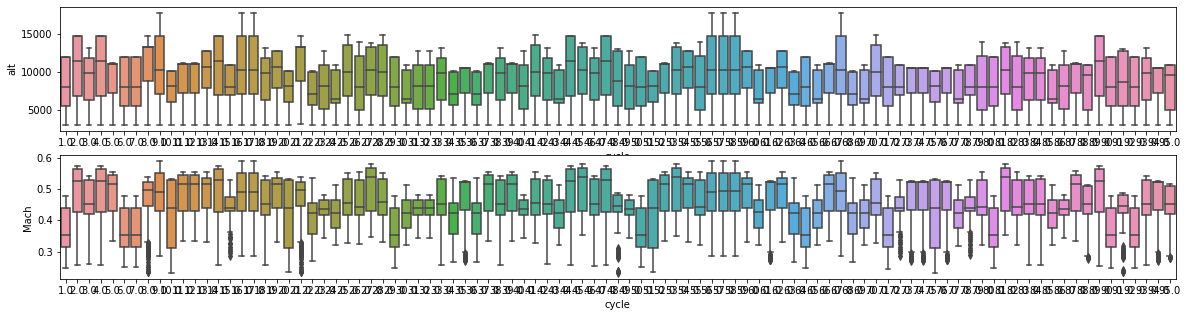

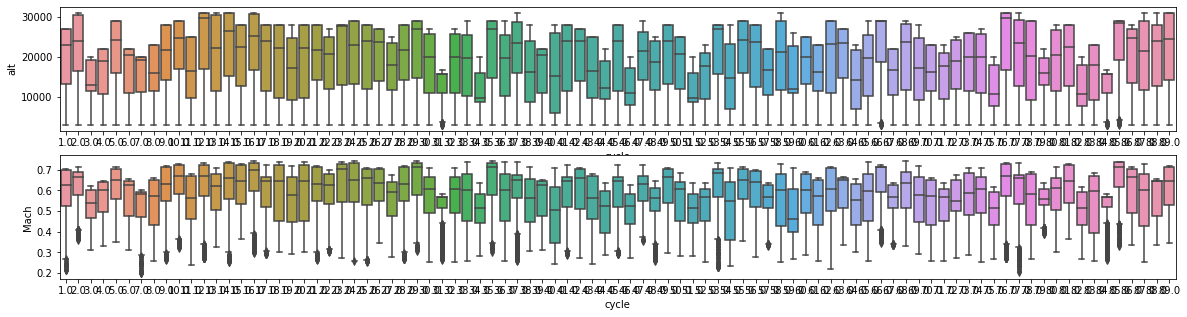

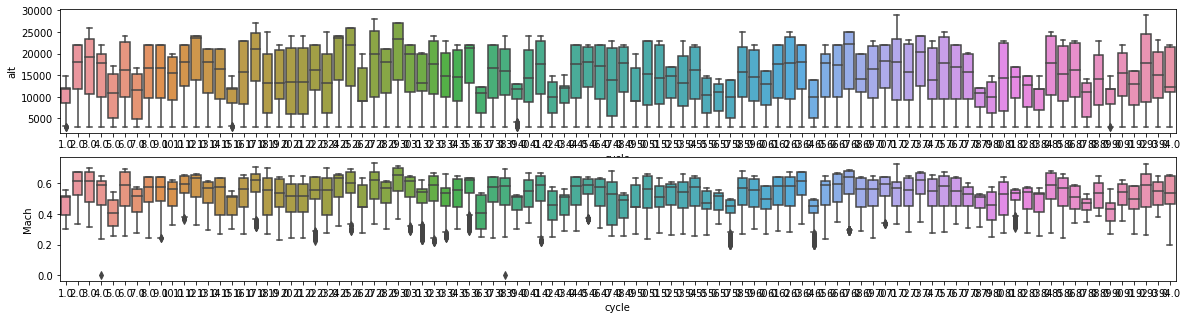

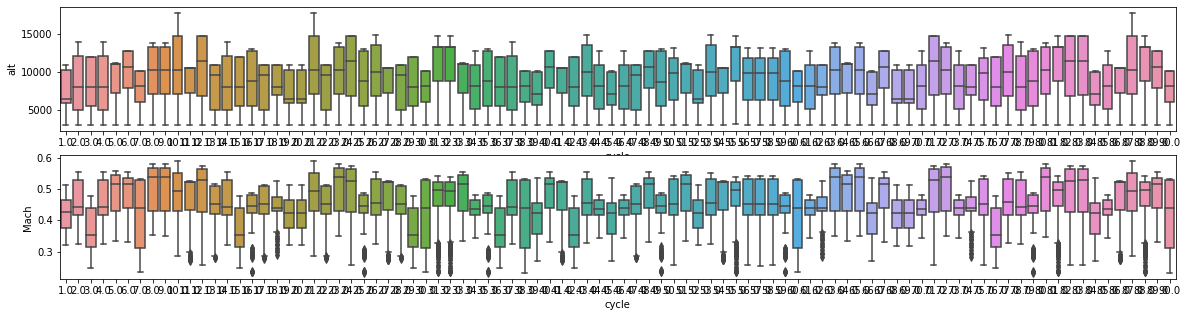

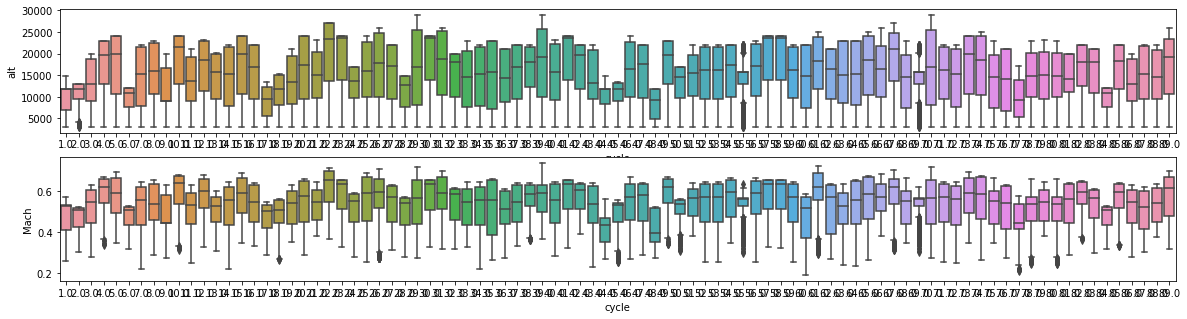

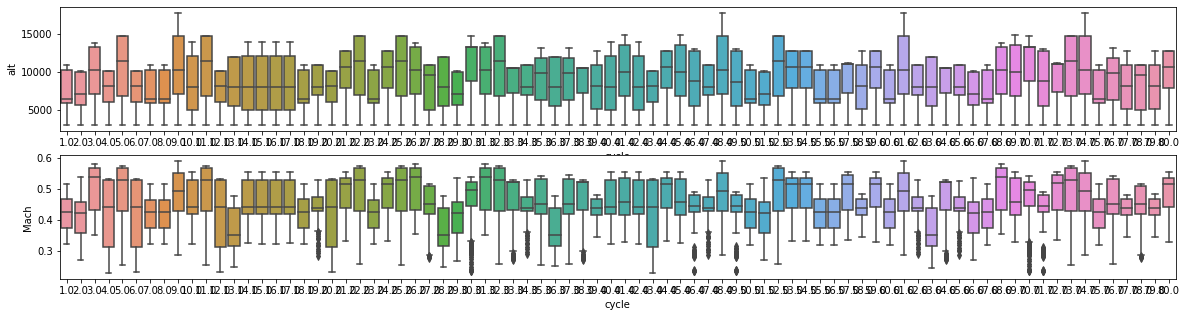

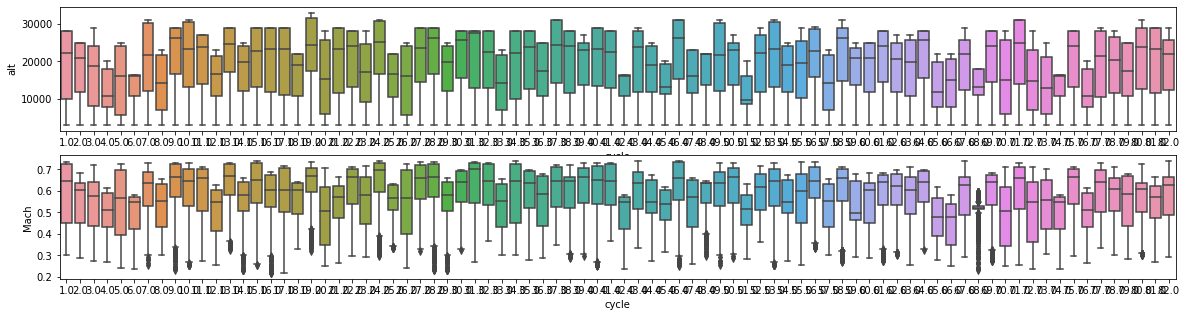

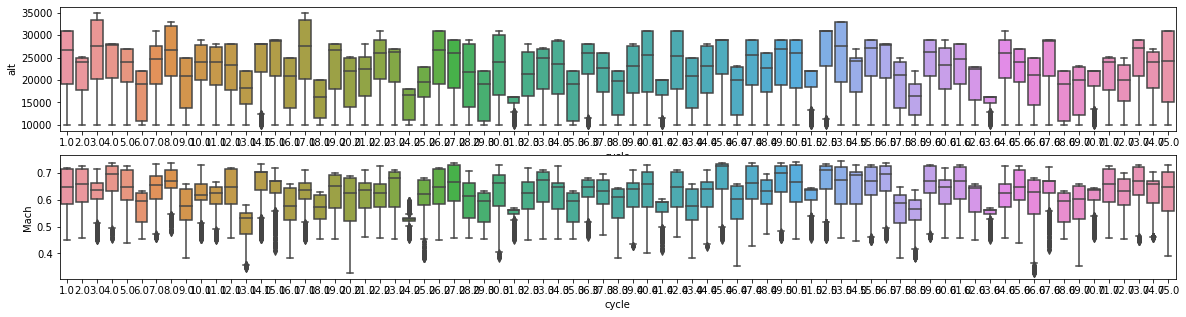

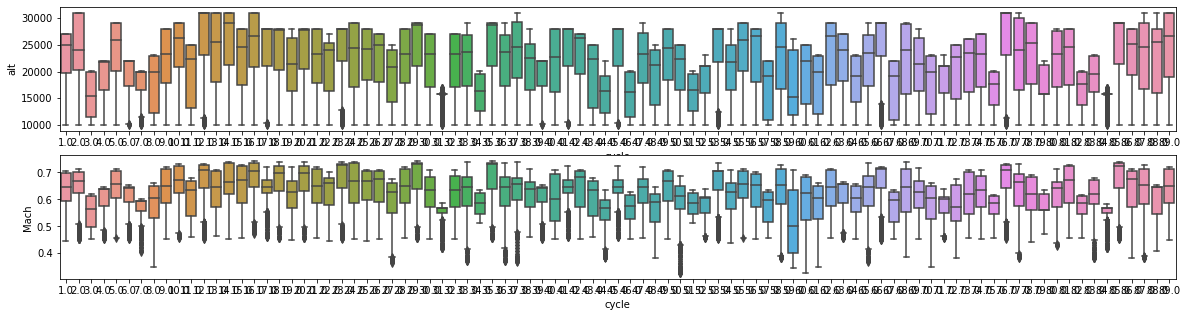

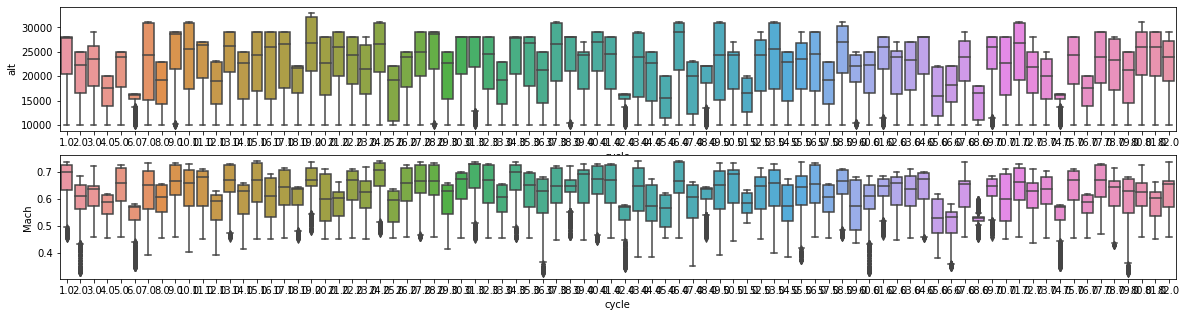

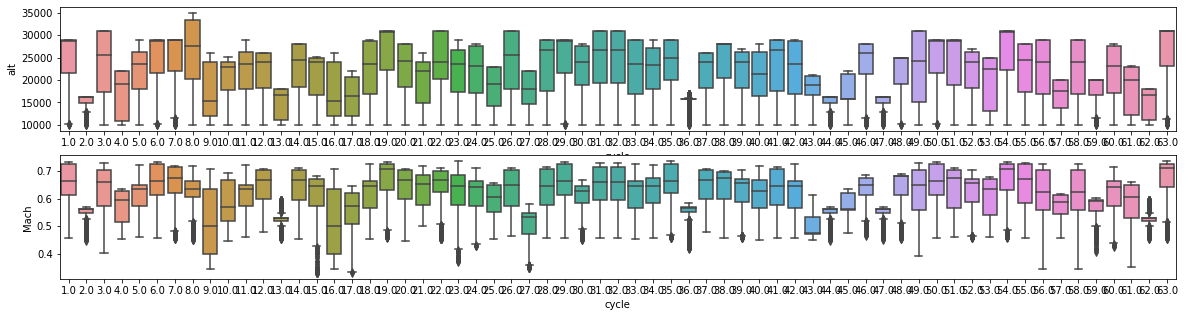

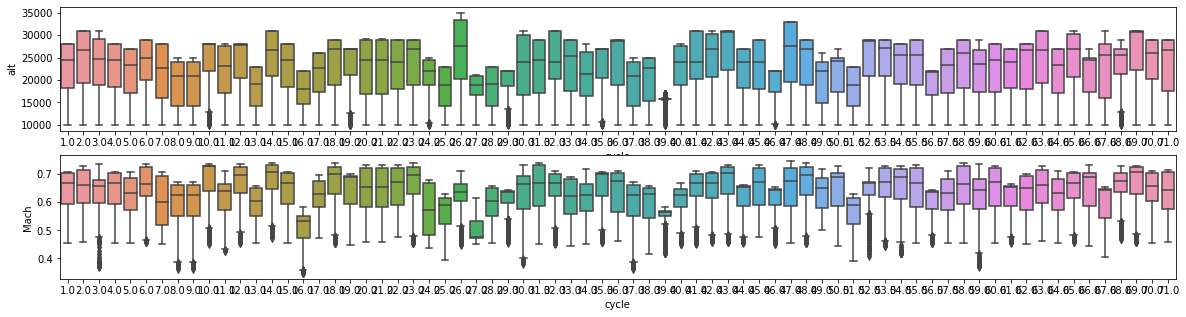

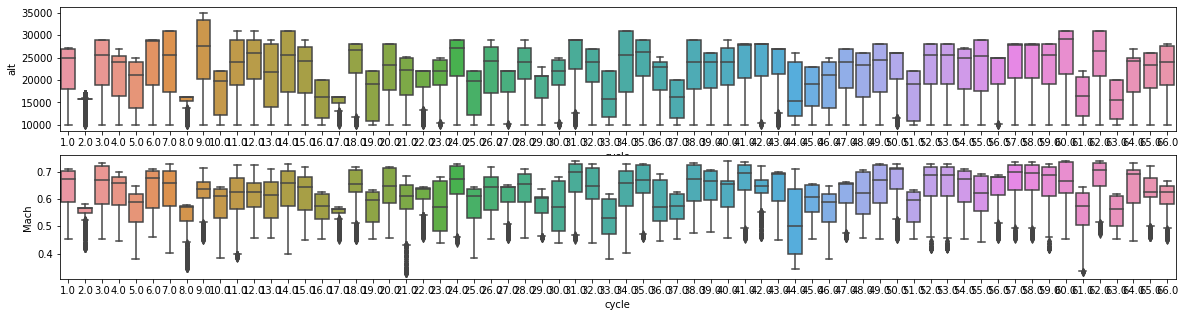

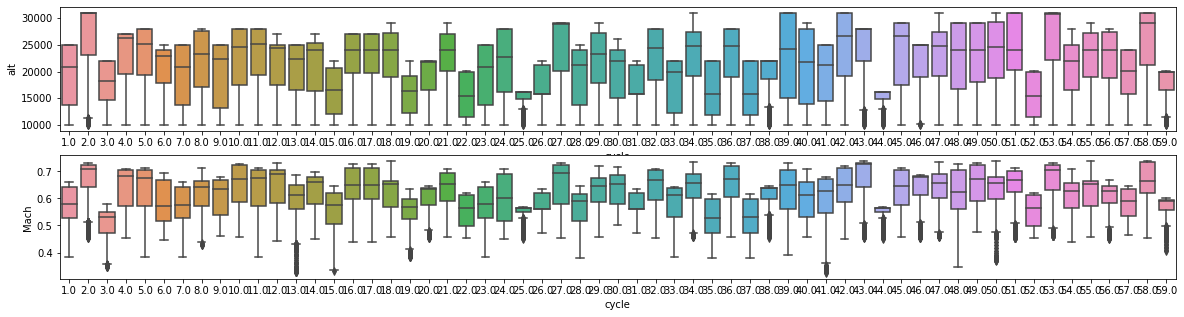

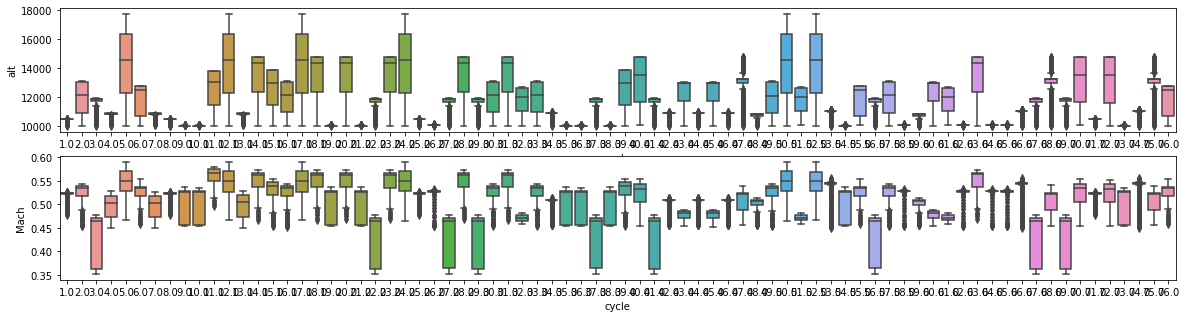

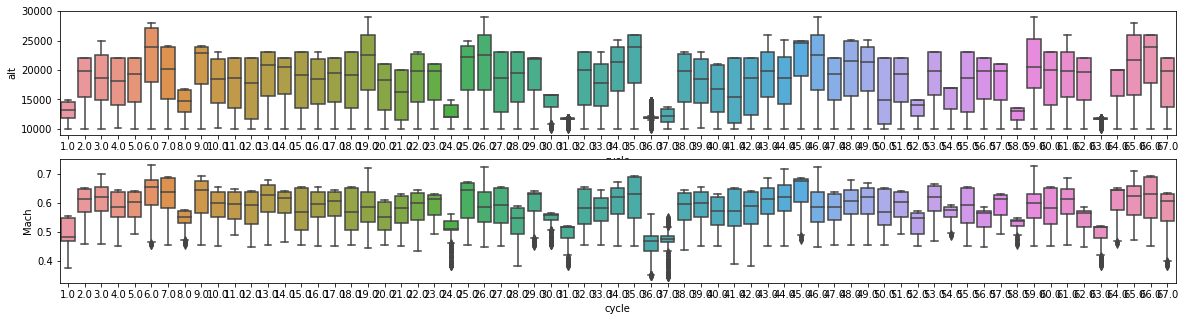

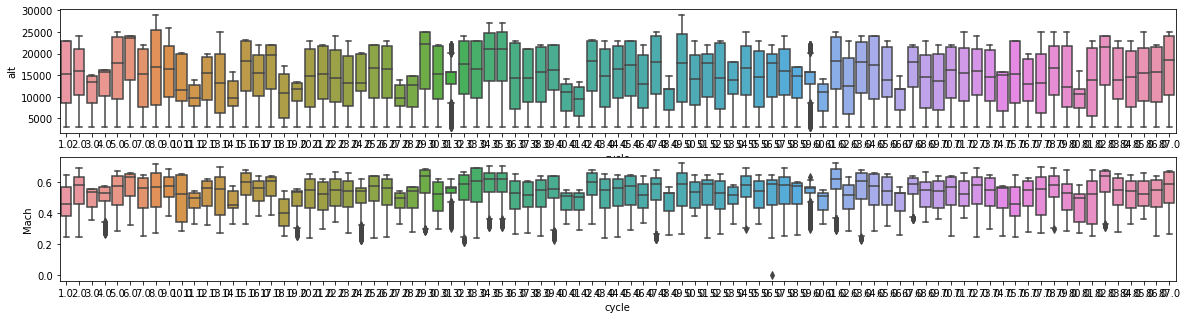

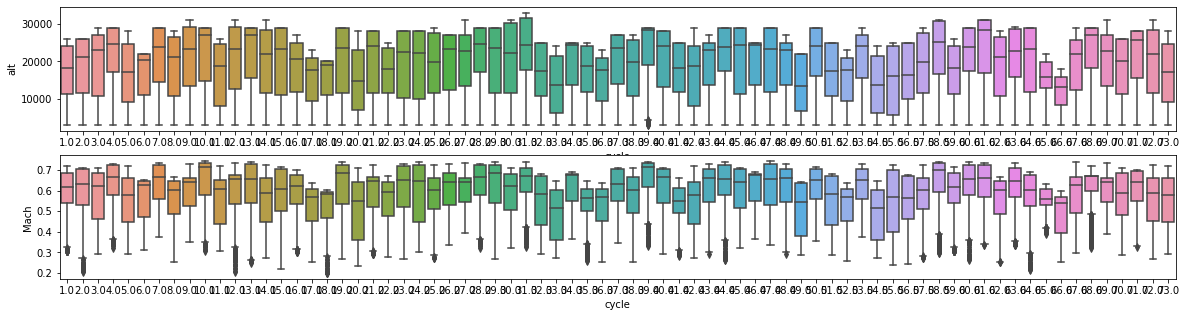

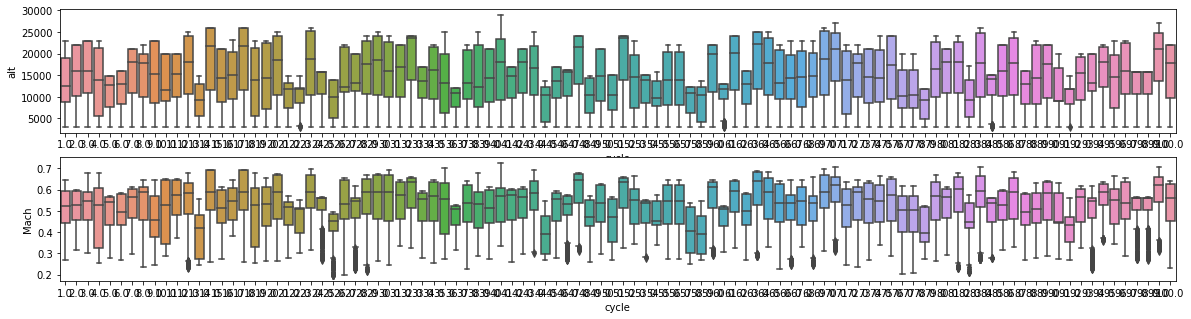

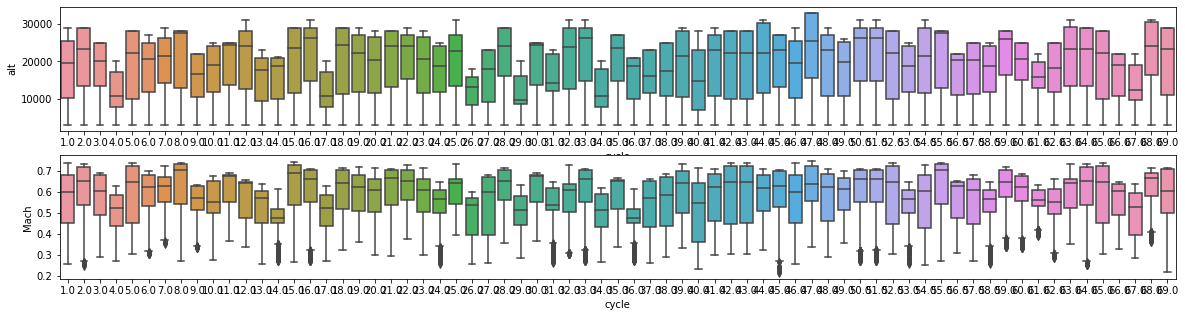

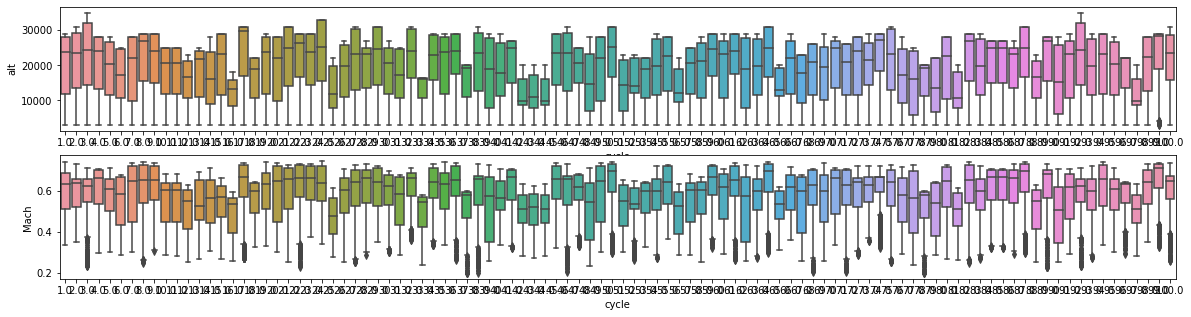

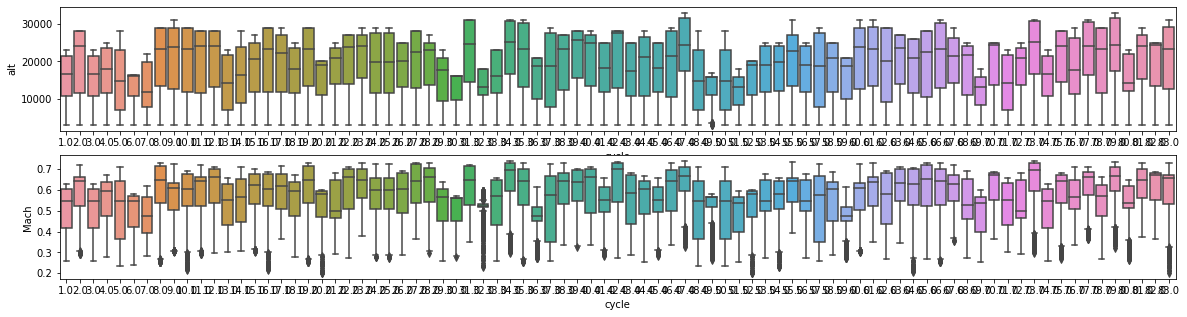

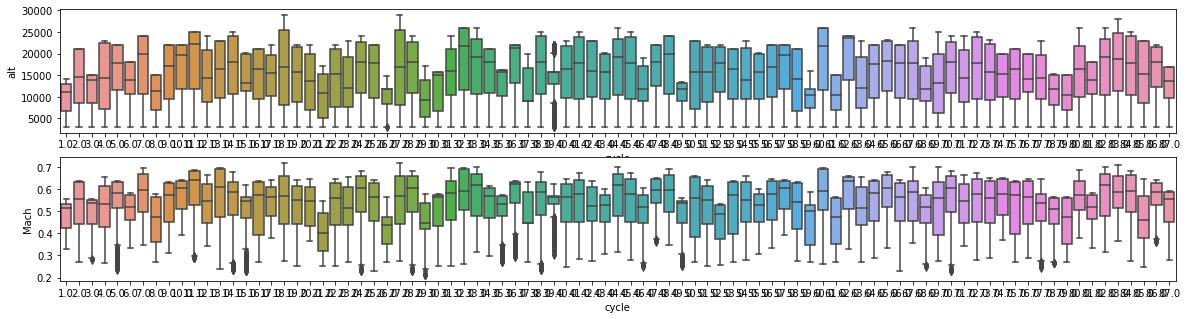

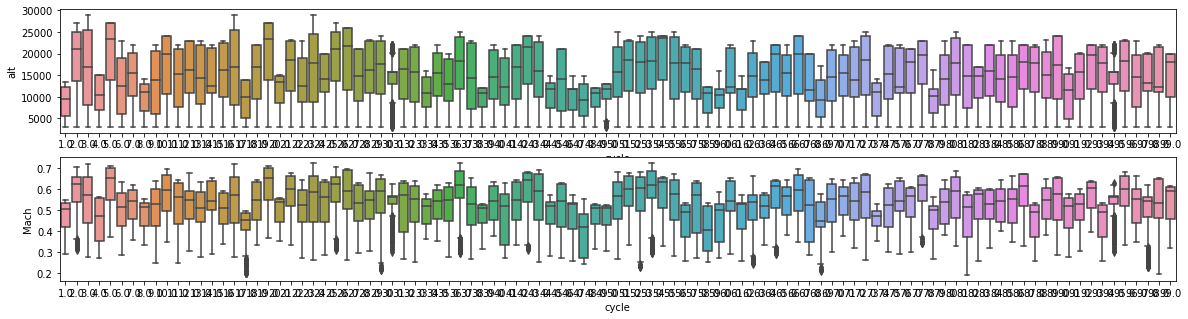

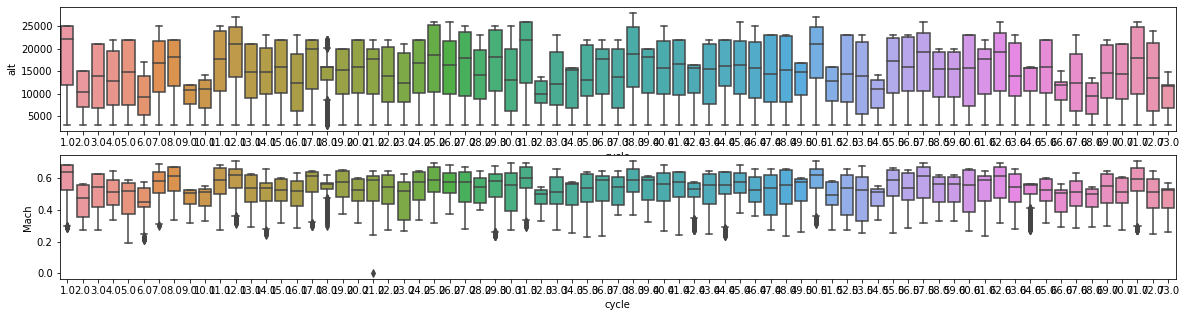

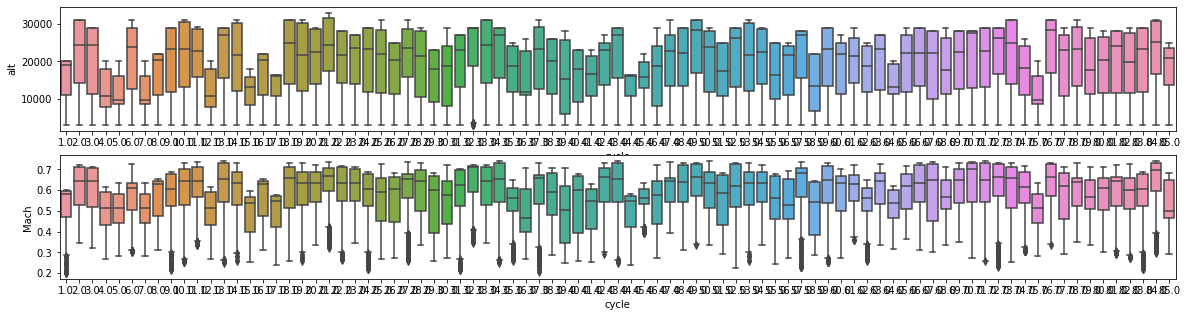

In [12]:
variables = ['alt', 'Mach']
for unit in df_A.unit.unique():
    df_u = df_W.loc[df_W['unit']==unit, :]
    plt.figure(figsize=(20, 5))
    for idl, variable in enumerate(variables):
        plt.subplot(len(variables), 1, idl+1)
        sns.boxplot(x=df_u['cycle'], y=df_u[variable])

## Degradation ($\theta$)

1.6. Tracer la dégradation du HPT et de la LPT pour chaque moteur, de manière a les voir sur le même graphique. Quel modèle vous semblerait correspondre? (10'/45')

In [13]:
df_T.describe()

fan_eff_mod  fan_flow_mod  LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  \
count  2.413911e+06  2.413911e+06    2413911.0     2413911.0    2413911.0   
mean  -4.741896e-03 -4.149514e-03          0.0           0.0          0.0   
std    1.590772e-02  1.128377e-02          0.0           0.0          0.0   
min   -2.234456e-01 -1.212087e-01          0.0           0.0          0.0   
25%   -1.759730e-03 -1.928594e-03          0.0           0.0          0.0   
50%    0.000000e+00  0.000000e+00          0.0           0.0          0.0   
75%    0.000000e+00  0.000000e+00          0.0           0.0          0.0   
max    2.749563e-05  5.235378e-05          0.0           0.0          0.0   

       HPC_flow_mod   HPT_eff_mod  HPT_flow_mod   LPT_eff_mod  LPT_flow_mod  \
count     2413911.0  2.413911e+06     2413911.0  2.413911e+06  2.413911e+06   
mean            0.0 -2.184318e-03           0.0 -4.655406e-04 -4.898265e-04   
std             0.0  3.548153e-03           0.0  1.867683e-03  1.721922e-03   
min             0.0 -1.880555e-02           0.0 -2.318372e-02 -2.142926e-02   
25%             0.0 -2.562446e-03           0.0  0.000000e+00  0.000000e+00   
50%             0.0 -8.819390e-04           0.0  0.000000e+00  0.000000e+00   
75%             0.0  0.000000e+00           0.0  0.000000e+00  0.000000e+00   
max             0.0  2.144234e-05           0.0  7.455901e-05  0.000000e+00   

               unit         cycle  
count  2.413911e+06  2.413911e+06  
mean   2.580149e+02  4.213013e+01  
std    1.768949e+02  2.499476e+01  
min    1.000000e+00  1.000000e+00  
25%    1.080000e+02  2.100000e+01  
50%    2.180000e+02  4.100000e+01  
75%    4.050000e+02  6.200000e+01  
max    5.100000e+02  1.000000e+02

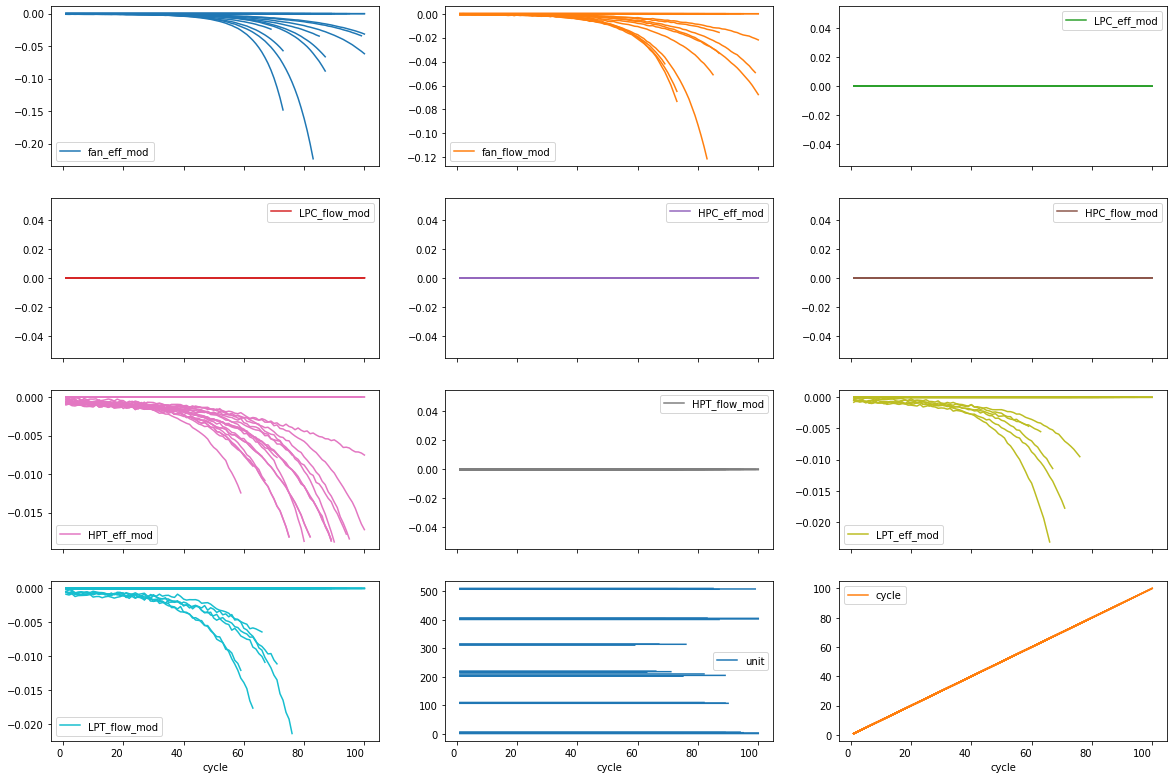

In [14]:
# Réponse
first = True
for u in df_A['unit'].unique():
    if first:
        df_tmp = df_T.loc[df_T['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_T['unit']==u]
        ax = df_tmp.plot(subplots=True, figsize=(20, 15), layout=(4, 3))
        first = False
    else:
        df_tmp = df_T.loc[df_T['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_T['unit']==u]
        df_tmp.plot(subplots=True, figsize=(20, 15), ax=ax)
for idk, ax1 in enumerate(plt.gcf().axes):
    ax1.legend([df_T.keys()[idk]])

## Sensor readings ($X_s$) & virtual sensor readings ($X_v$)

Le dataframe df_X_s contient les variables issues directement des capteurs.

In [15]:
df_X_s.describe()

unit         cycle           T48          Ps30            Nf  \
count  2.413911e+06  2.413911e+06  2.413911e+06  2.413911e+06  2.413911e+06   
mean   2.580149e+02  4.213013e+01  1.637888e+03  2.267308e+02  1.977443e+03   
std    1.768949e+02  2.499476e+01  1.162690e+02  5.555398e+01  1.750060e+02   
min    1.000000e+00  1.000000e+00  9.559214e+02  7.776220e+01  1.470914e+03   
25%    1.080000e+02  2.100000e+01  1.566041e+03  1.857738e+02  1.874909e+03   
50%    2.180000e+02  4.100000e+01  1.647097e+03  2.131784e+02  2.027333e+03   
75%    4.050000e+02  6.200000e+01  1.708772e+03  2.584789e+02  2.116230e+03   
max    5.100000e+02  1.000000e+02  1.985969e+03  4.532584e+02  2.291428e+03   

                 Nc            Wf  
count  2.413911e+06  2.413911e+06  
mean   8.228217e+03  2.433869e+00  
std    2.146268e+02  7.268910e-01  
min    7.347143e+03  3.358456e-01  
25%    8.095052e+03  1.928409e+00  
50%    8.222926e+03  2.237794e+00  
75%    8.354745e+03  2.811667e+00  
max    8.893840e+03  5.623772e+00

###  Une seule unité 
1.7 Tracer les variables Xs pour tous les vols de l'unité 2. Commentez. (7' / 52')

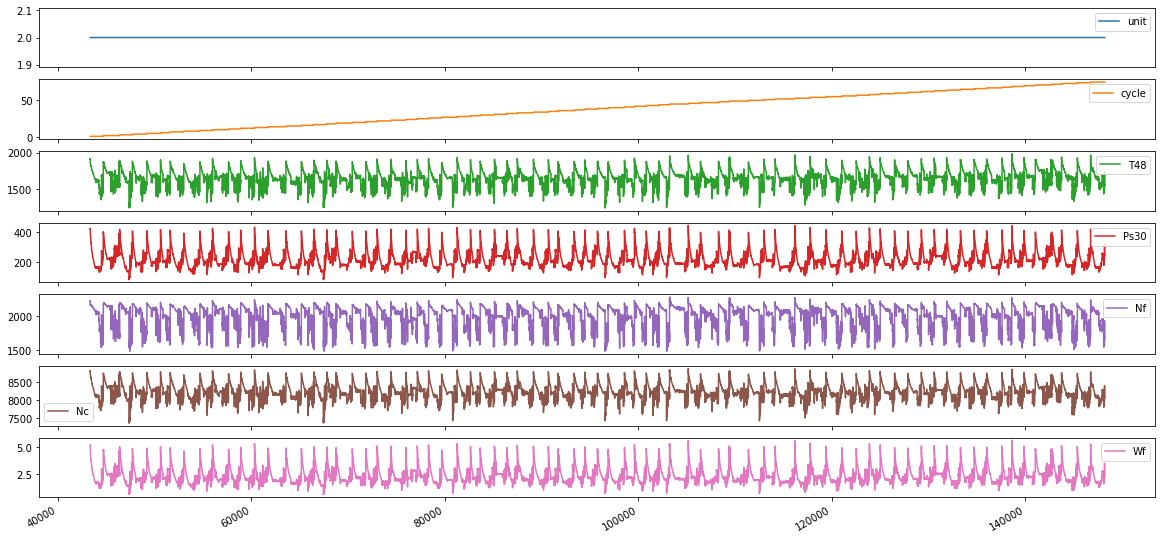

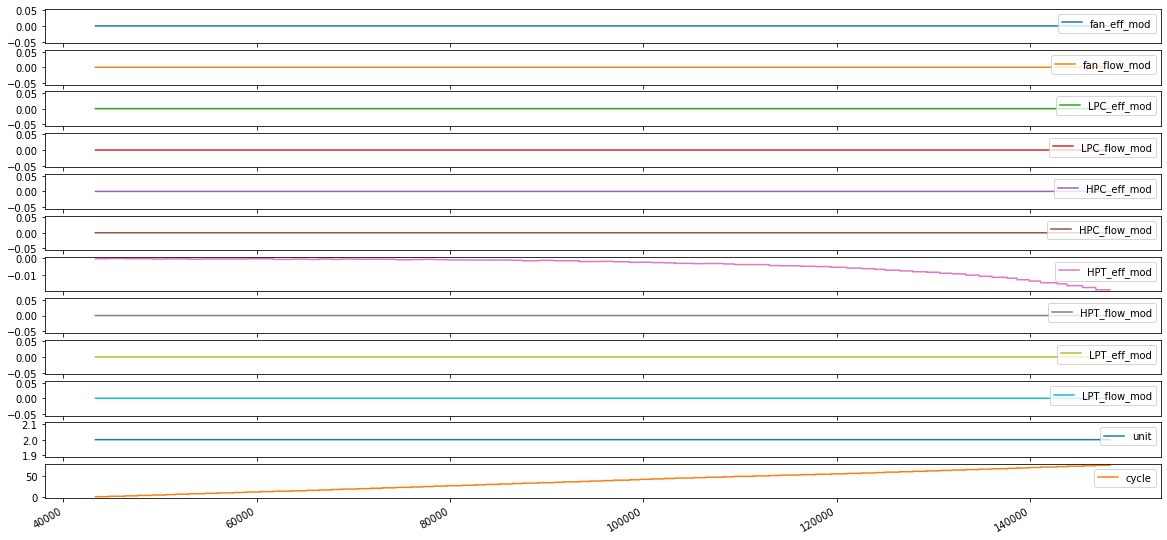

In [16]:
# Réponse
selected_unit = 2
df_X_s.loc[df_X_s['unit']==selected_unit].plot(subplots=True, figsize=(20, 10))

# On ne voit pas la dégradation
df_T.loc[df_T['unit']==selected_unit].plot(subplots=True, figsize=(20, 10));

###  Visualisation d'un cycle

1.8 Affichez les valeurs de X_s pour un seul cycle. (3' / 55')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

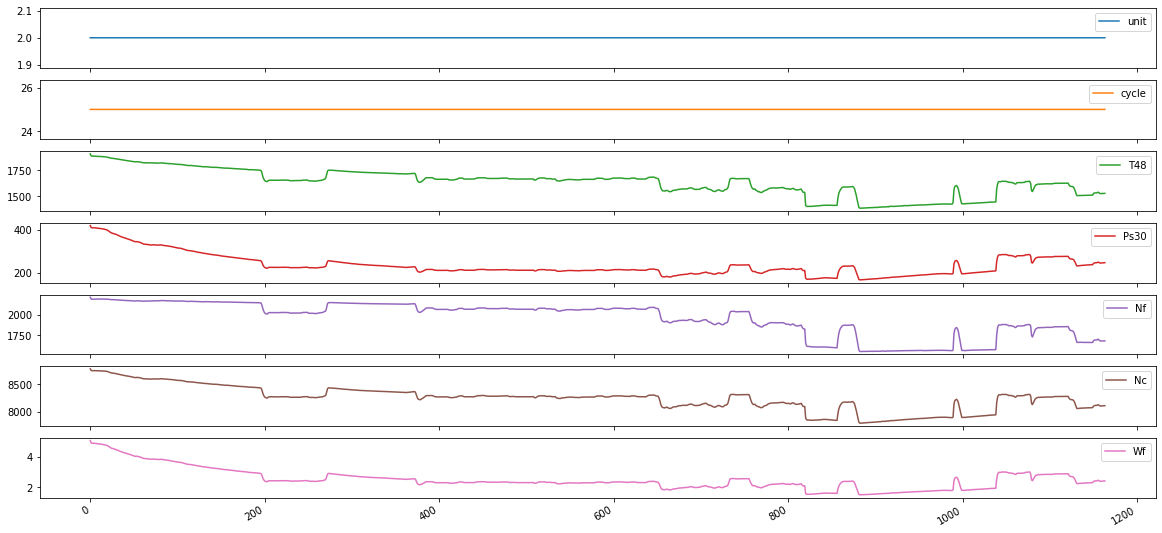

In [17]:
df_X_s_u_c = df_X_s.loc[(df_A.unit == 2) & (df_A.cycle == 25)]
df_X_s_u_c.reset_index(inplace=True, drop=True)
df_X_s_u_c.plot(subplots=True, figsize=(20, 10))

1.9 Affichez les variables l'une en fonction de l'autre. Que remarquez-vous ? (5' / 1h)

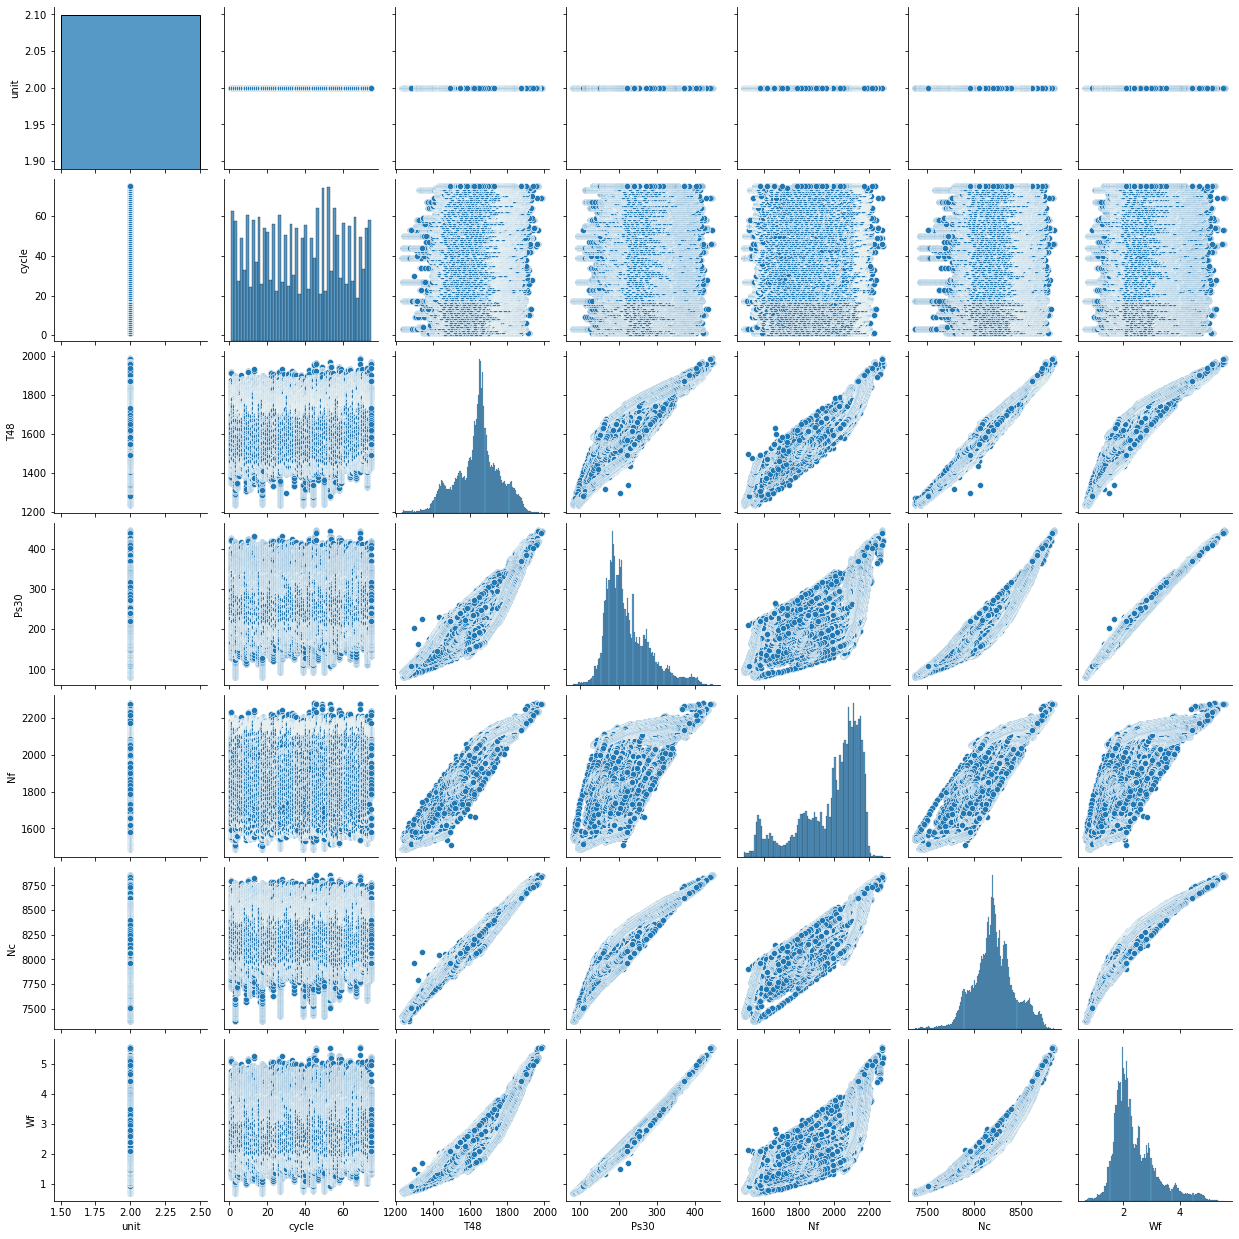

In [18]:
import seaborn as sns
sns.pairplot(df_X_s.loc[(df_A.unit == 2)])
# On remarque que les variables sont très corrélées.

# 2 Construction d'indicateurs 

Dans cette partie, nous allons essayer de construire un estimateur de la dégradation du moteur, et ce, de plusieurs manières.

Pour l'instant, on se restreint à l'unité 2.

2.1 Regardez l'évolution du max, du min et de la moyenne des variables de X_s. Calculez la corrélation avec HPT_eff_mod. Avez-vous trouvé un bon indicateur de la santé des moteurs ? (10'/1h10')

Variable cycle correlation -0.866384060864189
Variable T48 correlation -0.11466645124462965
Variable Ps30 correlation -0.020767912274853237
Variable Nf correlation 0.013446149925021125
Variable Nc correlation 0.01846309719120321
Variable Wf correlation -0.04398867085387708


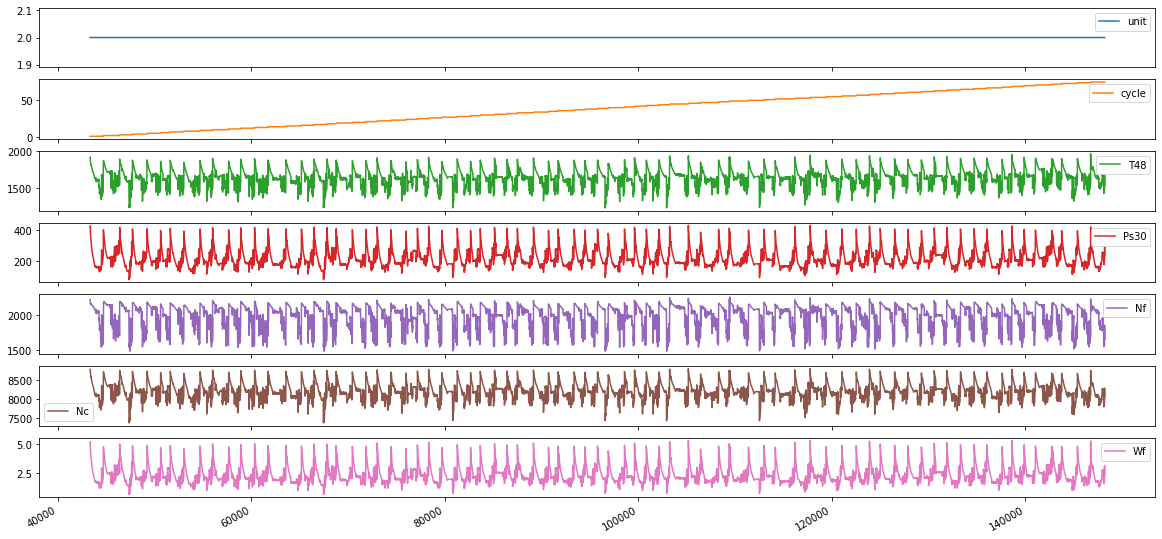

In [19]:
# réponse.
selected_unit = 2
df_X_s_sample = df_X_s.loc[df_A.unit == selected_unit, :]
df_X_s_sample.rolling(10, min_periods=0).mean().plot(subplots=True, figsize=(20, 10))

df_T_sample = df_T.loc[(df_A.unit == selected_unit)]
ground_truth = np.array(df_T_sample.loc[:, ["HPT_eff_mod"]]).flatten()

for variable in df_X_s_sample.keys():
    if variable != 'unit':
        rolling_mean = np.array(df_X_s_sample[variable].rolling(250, min_periods=0).mean())
        r = np.corrcoef(rolling_mean,  ground_truth)[0][1]
        print('Variable', variable, 'correlation', r)

# Vous pouvez changer mean par min ou max, et la taille de fenêtre.
# Le cycle, bien que corrélé, n'est pas un indicateur de santé

2.2 Le métier vous informe que la croisière est un mode de fonctionnement stable et comparable. Conditionnez aux altitudes supérieures à 29000 et Nf > 2000, et utilisez une moyenne glissante pour calcule un nouvel indicateur. Calculez la corrélation. Est-ce meilleur ? (10' / 1h20')

Variable cycle correlation -0.8227262603522975
Variable T48 correlation -0.431464532835153
Variable Ps30 correlation -0.18850583514641567
Variable Nf correlation 0.14701813900721009
Variable Nc correlation -0.015367755980098973
Variable Wf correlation -0.245876083193268


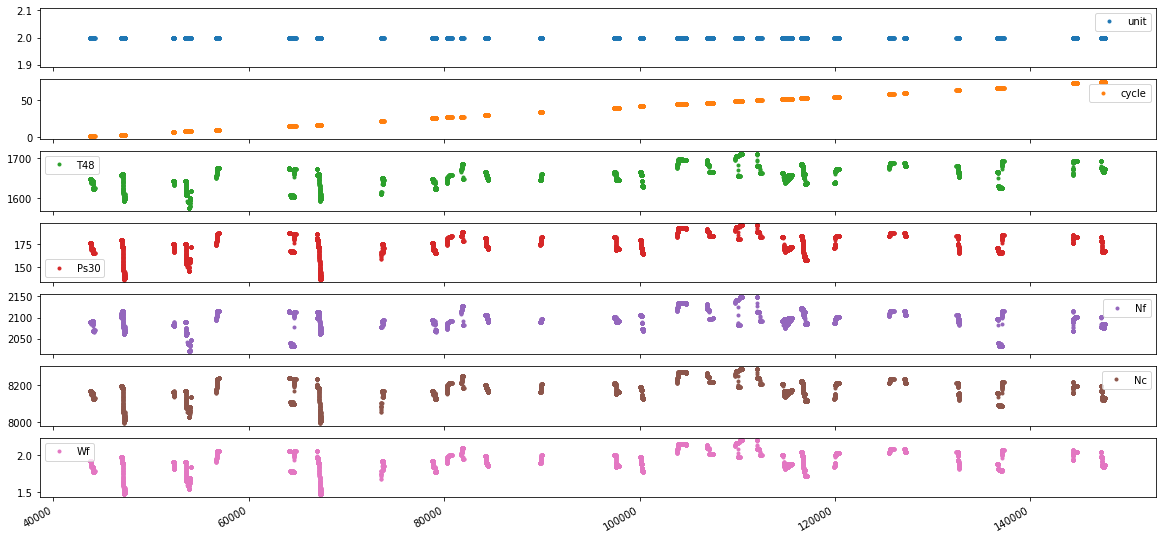

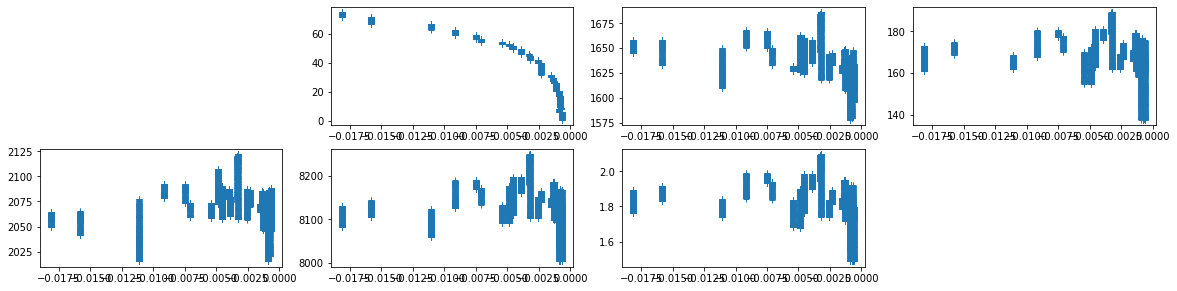

In [20]:
df_X_s_sample = df_X_s.loc[(df_A.unit == selected_unit) & (df_W['alt'] > 29000) & (df_X_s['Nf'] > 2000), :]
df_X_s_sample.rolling(100, min_periods=0).max().plot(subplots=True, figsize=(20, 10), style='.')

df_T_sample = df_T.loc[(df_A.unit == selected_unit) 
                       & (df_W['alt'] > 29000) & (df_X_s['Nf'] > 2000), :]
ground_truth = np.array(df_T_sample.loc[:, ["HPT_eff_mod"]]).flatten()
plt.figure(figsize=(20, 10))
for idp, variable in enumerate(df_X_s_sample.keys()):
    if variable != 'unit':
        rolling_mean = np.array(df_X_s_sample[variable].rolling(250, min_periods=0).mean())
        r = np.corrcoef(rolling_mean,  ground_truth)[0][1]
        print('Variable', variable, 'correlation', r)
        plt.subplot(4, 4, idp+1)
        plt.plot(ground_truth, rolling_mean, '+')

2.3 Apprenez un modèle qui prédit Wf à partir des autres variables, sur les 10000 premiers échantillons. Utilisez ce modèle pour faire un indicateur par résidu, puis calculer sa corrélation avec la dégradation HPT eff mod. (15'/1h25')

In [21]:
selected_unit = 2
from sklearn.linear_model import LinearRegression
myLR = LinearRegression()
df_X_s_sample = df_X_s.loc[(df_A.unit == selected_unit)].reset_index(drop=True)
df_X_s_sample.keys()

Index(['unit', 'cycle', 'T48', 'Ps30', 'Nf', 'Nc', 'Wf'], dtype='object')

In [22]:
X = df_X_s_sample.loc[0:10000, ['T48', 'Ps30', 'Nf', 'Nc']]
y = df_X_s_sample.loc[0:10000, ['Wf']]

print(X.shape, y.shape)
myLR.fit(X=X, y=y)

(10001, 4) (10001, 1)


LinearRegression()

(104909, 12)
(94909,) (94909, 1)
correlation 0.3267877193239918


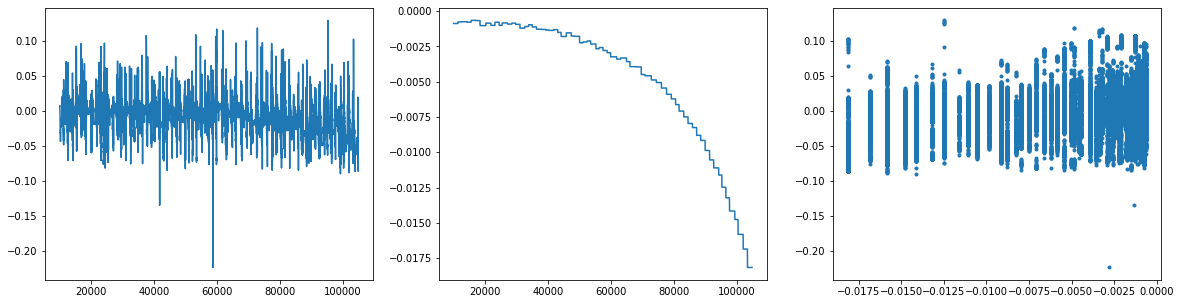

In [23]:
X_test = df_X_s_sample.loc[10000:, ['T48', 'Ps30', 'Nf', 'Nc']]
y_test = df_X_s_sample.loc[10000:, ['Wf']]
y_hat = myLR.predict(X_test)
df_T_sample = df_T.loc[(df_A.unit == selected_unit)]
print(df_T_sample.shape)
ground_truth = np.array(df_T_sample.loc[:, ["HPT_eff_mod"]]).flatten()
ground_truth = ground_truth[10000:]
print(ground_truth.shape, y_hat.shape)
r = np.corrcoef(np.array(y_test-y_hat).flatten(),  ground_truth)[0][1]
print('correlation', r)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(y_test-y_hat)
plt.subplot(1, 3, 2)
plt.plot(X_test.index, ground_truth)
plt.subplot(1, 3, 3)
plt.plot(ground_truth, y_test-y_hat, '.')


2.4 Proposez une manière d'améliorer votre résultat. (20', 1h45')

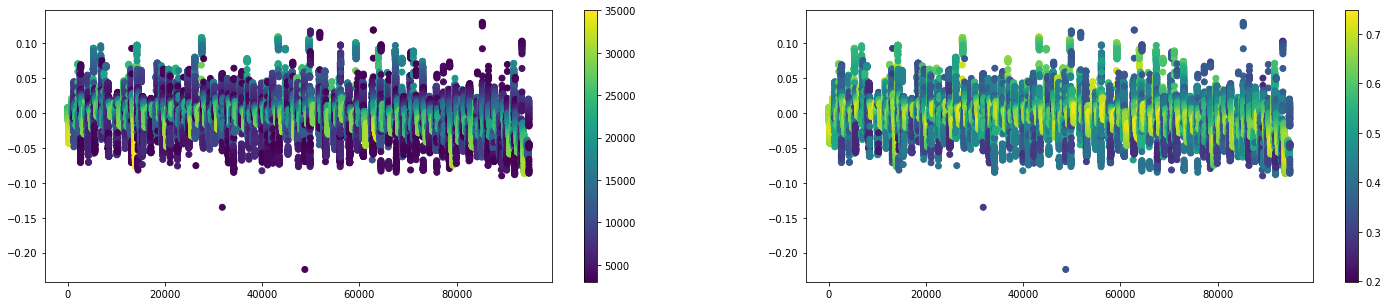

In [24]:
# Réponse 1 : le conditionnement
df_W_sample = df_W.loc[(df_A.unit == selected_unit)].reset_index(drop=True)
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(y_test)), y_test-y_hat, c=df_W_sample.loc[10000:, 'alt'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(y_test)), y_test-y_hat, c=df_W_sample.loc[10000:, 'Mach'])
plt.colorbar();
# Ici on peut voir que les conditions extérieures changent le positionnement du résidu

(9860, 7)
(1001, 4) (1001, 1)
(8860, 4) (8860, 1)
correlation 0.9008723848654434


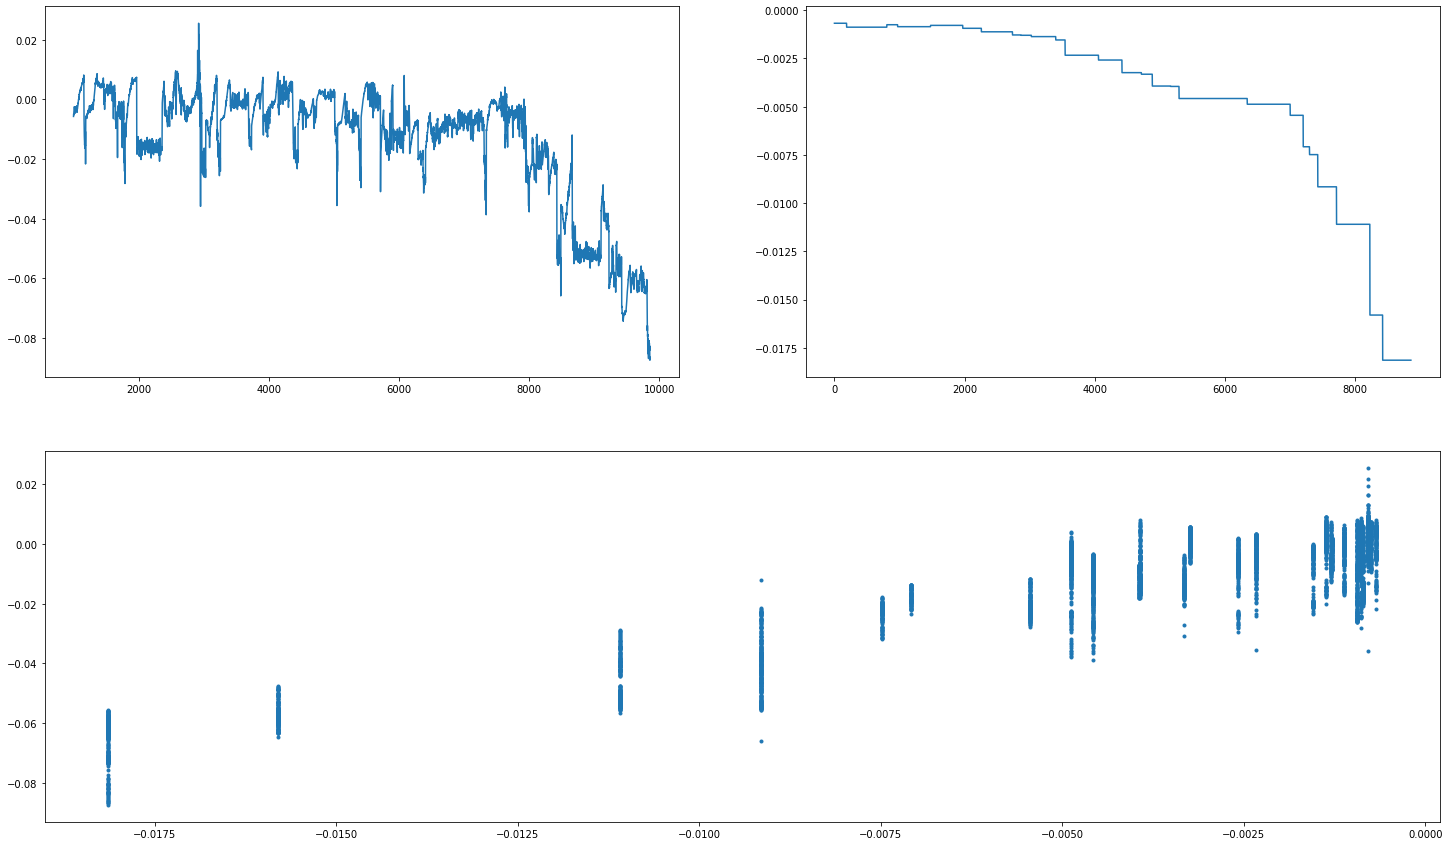

In [25]:
df_X_s_sample = df_X_s.loc[(df_A.unit == selected_unit) & (df_W['alt']>29000)].reset_index(drop=True)
print(df_X_s_sample.shape)
X = df_X_s_sample.loc[0:1000, ['T48', 'Ps30', 'Nf', 'Nc']]
y = df_X_s_sample.loc[0:1000, ['Wf']]
print(X.shape, y.shape)
myLR.fit(X=X, y=y)
X_test = df_X_s_sample.loc[1000:, ['T48', 'Ps30', 'Nf', 'Nc']]
y_test = df_X_s_sample.loc[1000:, ['Wf']]
y_hat = myLR.predict(X_test)
print(X_test.shape, y_test.shape)

df_T_sample = df_T.loc[(df_A.unit == 2) & 
                       (df_W['alt']>29000)].reset_index(drop=True)
ground_truth = np.array(df_T_sample.loc[:, ["HPT_eff_mod"]]).flatten()
ground_truth = ground_truth[1000:]
r = np.corrcoef(np.array(y_test-y_hat).flatten(),  ground_truth)[0][1]
print('correlation', r)
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(y_test-y_hat)
plt.subplot(2, 2, 2)
plt.plot(ground_truth)
plt.subplot(2, 1, 2)
plt.plot(ground_truth, y_test-y_hat, '.')

(9860, 7)
correlation -0.6768568480764592


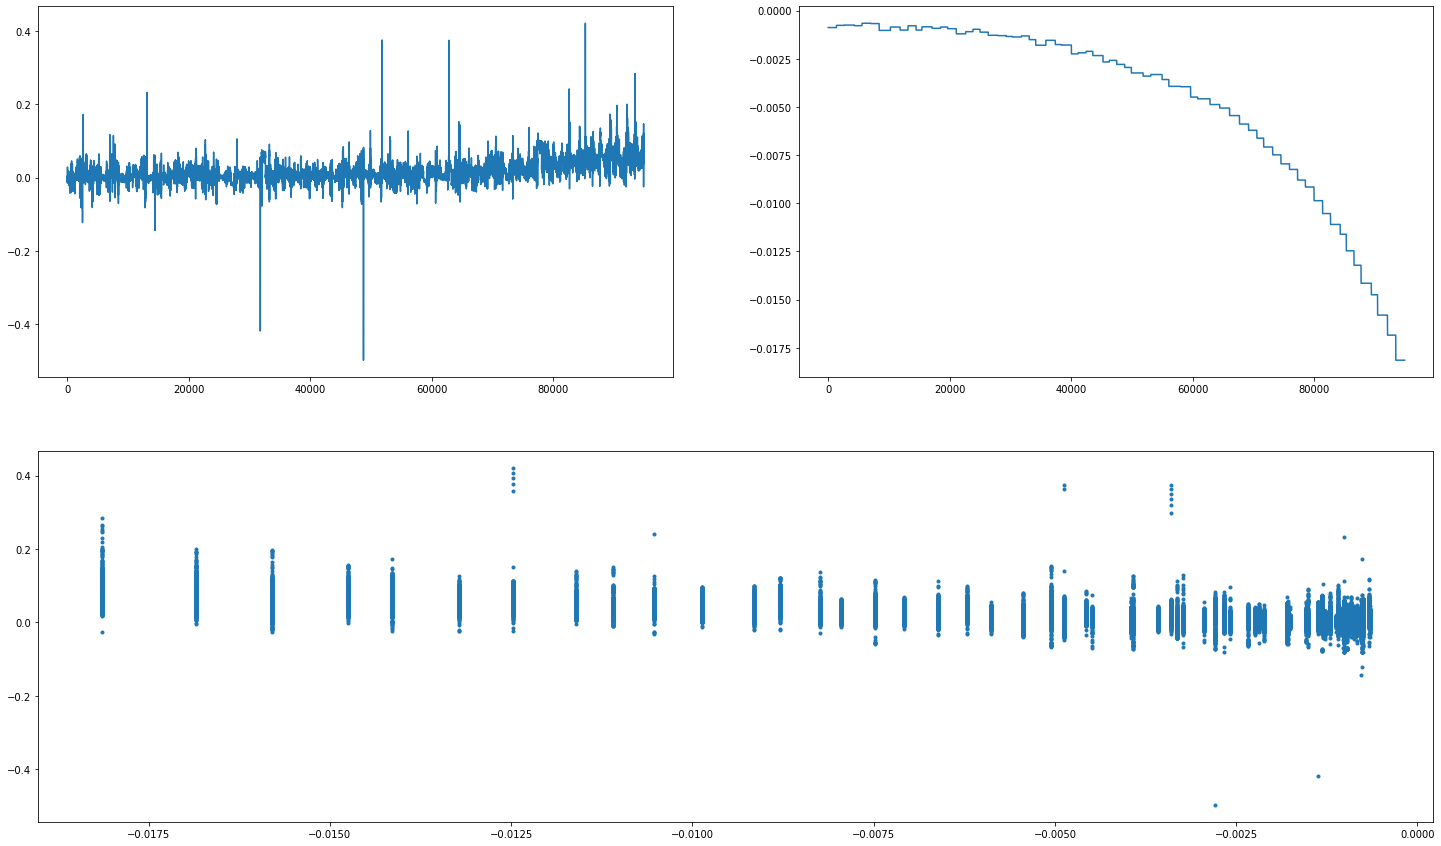

In [26]:
# Réponse 2 : un meilleur modèle / un modèle plus puissant
print(df_X_s_sample.shape)
from sklearn.ensemble import RandomForestRegressor
myRF = RandomForestRegressor()
df_X_s_sample = df_X_s.loc[(df_A.unit == selected_unit)].reset_index(drop=True)
df_X_s_sample.keys()
X = df_X_s_sample.loc[0:10000, ['T48', 'Ps30', 'Nf', 'Nc']]
y = np.array(df_X_s_sample.loc[0:10000, ['Wf']]).flatten()

myRF.fit(X=X, y=y)
X_test = df_X_s_sample.loc[10000:, ['T48', 'Ps30', 'Nf', 'Nc']]
y_test = np.array(df_X_s_sample.loc[10000:, ['Wf']]).flatten()
y_hat = myRF.predict(X_test)

df_T_sample = df_T.loc[(df_A.unit == selected_unit)].reset_index(drop=True)
ground_truth = np.array(df_T_sample.loc[10000:, ["HPT_eff_mod"]]).flatten()
r = np.corrcoef(np.array(y_test-y_hat).flatten(),  ground_truth)[0][1]
print('correlation', r)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(y_test-y_hat)
plt.subplot(2, 2, 2)
plt.plot(ground_truth)
plt.subplot(2, 1, 2)
plt.plot(ground_truth, y_test-y_hat, '.')


Maintenant, nous allons essayer de généraliser sur les autres moteurs.

2.5 Retirez de l'étude les vols sans dégradation HPT mod. Apprenez un modèle linéaire sur les 10000 premiers échantillons sur le moteur 2, et ce, conditionné à 1.5x l'altitude minimale. Testez le sur les autres moteurs, et calculez la corrélation avec HPT_eff_mod. Que pouvez-vous en déduire ? (15' / 2h)

In [27]:
list_units_filtered = []
for u in df_A.unit.unique():
    if df_T.HPT_eff_mod.loc[(df_A.unit == u)].min() != df_T.HPT_eff_mod.loc[(df_A.unit == u)].max():
        list_units_filtered.append(u)
print(list_units_filtered) 

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 107.0, 108.0, 109.0, 110.0, 202.0, 205.0, 210.0, 216.0, 218.0, 220.0, 311.0, 314.0, 315.0]


In [28]:
print(df_X_s_sample.shape)
from sklearn.linear_model import LinearRegression
myLR = LinearRegression()


alt_limit = (1.5 * np.min(df_W['alt']))  
df_res = pd.DataFrame(columns=['Train', 'Test', 'CoeffCorr'])
for u_train in list_units_filtered:
    df_X_s_sample = df_X_s.loc[(df_A.unit == u_train)].reset_index(drop=True)
    df_W_sample = df_W.loc[(df_A.unit == u_train)].reset_index(drop=True)
      
    df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit) ]
    print('sample', df_X_s_sample.shape)
    X = df_X_s_sample.loc[:30000, ['T48', 'Ps30', 'Nf', 'Nc']]
    y = df_X_s_sample.loc[:30000, ['Wf']]
    myLR.fit(X=X, y=y)
    for u_test in list_units_filtered:
        if u_test != u_train:
            df_X_s_sample = df_X_s.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_W_sample = df_W.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit)]
            df_T_sample = df_T.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_T_sample = df_T_sample.loc[(df_W_sample['alt'] > alt_limit )]        
            X_test = df_X_s_sample.loc[:, ['T48', 'Ps30', 'Nf', 'Nc']]
            y_test = df_X_s_sample.loc[:, ['Wf']]
            y_hat = myLR.predict(X_test)
            ground_truth = df_T_sample.loc[:, ["HPT_eff_mod"]]
            r = np.corrcoef(np.array(y_test-y_hat).flatten(),  np.array(ground_truth).flatten())[0][1]
            print('correlation, learn', u_train, 'tested:', u_test, ': ', r)
            df_r = pd.DataFrame([[u_train, u_test, r]],
                                columns=['Train', 'Test', 'CoeffCorr'], index=[0])
            df_res = df_res.append(df_r,
                                   ignore_index=True)

(104909, 7)
sample (37534, 7)
correlation, learn 1.0 tested: 2.0 :  0.721650178030573
correlation, learn 1.0 tested: 3.0 :  0.5770372762764924
correlation, learn 1.0 tested: 4.0 :  0.8810160142863726
correlation, learn 1.0 tested: 5.0 :  0.838773250340551
correlation, learn 1.0 tested: 6.0 :  0.8786274951246121
correlation, learn 1.0 tested: 107.0 :  0.9006681480080598
correlation, learn 1.0 tested: 108.0 :  0.8823565024789285
correlation, learn 1.0 tested: 109.0 :  0.8677058472003849
correlation, learn 1.0 tested: 110.0 :  0.7981735337515924
correlation, learn 1.0 tested: 202.0 :  0.7131554519955281
correlation, learn 1.0 tested: 205.0 :  0.8444039921090201
correlation, learn 1.0 tested: 210.0 :  0.8008997648455005
correlation, learn 1.0 tested: 216.0 :  0.766492858041493
correlation, learn 1.0 tested: 218.0 :  0.7005906781055877
correlation, learn 1.0 tested: 220.0 :  0.4939840776817344
correlation, learn 1.0 tested: 311.0 :  0.834695417827256
correlation, learn 1.0 tested: 314.0 :  

correlation, learn 108.0 tested: 220.0 :  0.6573765632462173
correlation, learn 108.0 tested: 311.0 :  0.896544104462005
correlation, learn 108.0 tested: 314.0 :  0.9469865042914982
correlation, learn 108.0 tested: 315.0 :  0.9066676821899591
sample (30269, 7)
correlation, learn 109.0 tested: 1.0 :  0.7673734972456793
correlation, learn 109.0 tested: 2.0 :  0.5765818094159841
correlation, learn 109.0 tested: 3.0 :  0.4165568458397546
correlation, learn 109.0 tested: 4.0 :  0.7976329888612324
correlation, learn 109.0 tested: 5.0 :  0.7260396258768991
correlation, learn 109.0 tested: 6.0 :  0.761182250803217
correlation, learn 109.0 tested: 107.0 :  0.8267786702867438
correlation, learn 109.0 tested: 108.0 :  0.7613474901075735
correlation, learn 109.0 tested: 110.0 :  0.6746517826602514
correlation, learn 109.0 tested: 202.0 :  0.5699485817303513
correlation, learn 109.0 tested: 205.0 :  0.7370525019557248
correlation, learn 109.0 tested: 210.0 :  0.6826565449332305
correlation, learn 1

correlation, learn 220.0 tested: 108.0 :  0.7330258586264624
correlation, learn 220.0 tested: 109.0 :  0.5919918798699968
correlation, learn 220.0 tested: 110.0 :  0.7819757886759023
correlation, learn 220.0 tested: 202.0 :  0.8010073853339449
correlation, learn 220.0 tested: 205.0 :  0.879469544363313
correlation, learn 220.0 tested: 210.0 :  0.8561236464127393
correlation, learn 220.0 tested: 216.0 :  0.8337723823344682
correlation, learn 220.0 tested: 218.0 :  0.7706484308024718
correlation, learn 220.0 tested: 311.0 :  0.857628051737287
correlation, learn 220.0 tested: 314.0 :  0.8069145561306189
correlation, learn 220.0 tested: 315.0 :  0.7970566513719175
sample (66350, 7)
correlation, learn 311.0 tested: 1.0 :  0.6644934628682643
correlation, learn 311.0 tested: 2.0 :  0.7492486679532394
correlation, learn 311.0 tested: 3.0 :  0.42300803310023355
correlation, learn 311.0 tested: 4.0 :  0.6960342561530626
correlation, learn 311.0 tested: 5.0 :  0.8294497370496777
correlation, lear

In [29]:
meta_res = pd.DataFrame(np.array([df_res.groupby('Train').CoeffCorr.mean(),
                         df_res.groupby('Train').CoeffCorr.std()]).T, columns=['Mean Coeff', 'Std Coeff'])
print(meta_res)

    Mean Coeff  Std Coeff
0     0.793029   0.115013
1     0.579268   0.149093
2     0.859721   0.069360
3     0.746653   0.130492
4     0.774876   0.107867
5     0.851095   0.083665
6     0.730830   0.137595
7     0.853746   0.081532
8     0.669957   0.149684
9     0.746264   0.116443
10    0.590396   0.144243
11    0.757295   0.111569
12    0.760394   0.115423
13    0.673436   0.131223
14    0.759731   0.115095
15    0.737613   0.123015
16    0.742784   0.113487
17    0.165588   0.115506
18    0.784519   0.106755


En réalité, on ne peux faire des essais qui estiment HPT_eff_mod qu'une fois de temps en temps. Pour simplifier, nous prendrons une mesure une fois tous les 10000 échantillons.

2.6 Estimez "HPT_eff_mod" à partir de l'indicateur proposé, et calculez la RMSE. Affichez votre résultat. Que pouvez-vous dire sur l'estimation ? (10', 2h10')

(15678, 7)
learn 1.0 rmse: 0.00564922274107268
learn 2.0 rmse: 0.004227992869013453
learn 3.0 rmse: 0.002579349367288772
learn 4.0 rmse: 0.0025821903091121476
learn 5.0 rmse: 0.004125438346409888
learn 6.0 rmse: 0.002752578923419566
learn 107.0 rmse: 0.005129742737800816
learn 108.0 rmse: 0.003278535341373414
learn 109.0 rmse: 0.005921444321634696
learn 110.0 rmse: 0.0024777768488448803
learn 202.0 rmse: 0.0036503885116305193
learn 205.0 rmse: 0.003086252756288975
learn 210.0 rmse: 0.0027034953977619182
learn 216.0 rmse: 0.003122743759358202
learn 218.0 rmse: 0.0032992187924839366
learn 220.0 rmse: 0.002537596158592182
learn 311.0 rmse: 0.0027941403003445674
learn 314.0 rmse: 0.002671734504903743
learn 315.0 rmse: 0.0021055119048866513
    Training  rmse residuals
0        1.0        0.005649
1        2.0        0.004228
2        3.0        0.002579
3        4.0        0.002582
4        5.0        0.004125
5        6.0        0.002753
6      107.0        0.005130
7      108.0        0.

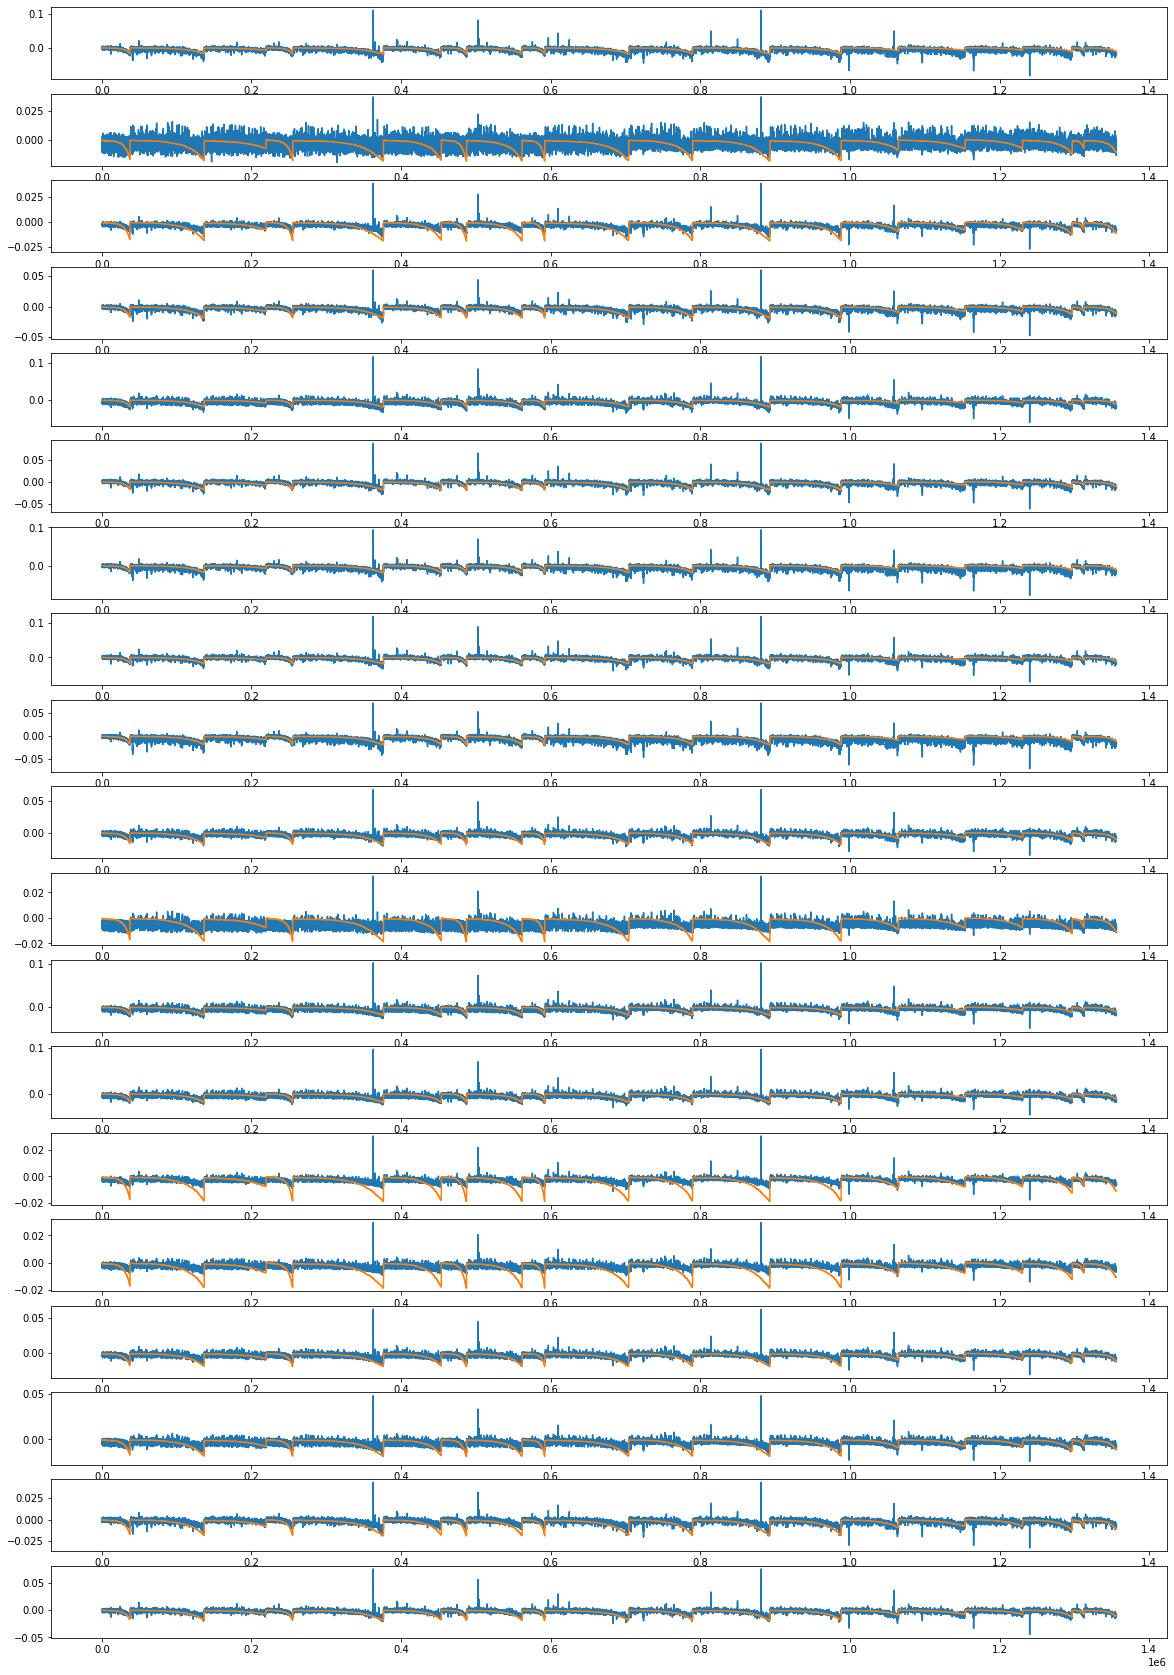

In [30]:
print(df_X_s_sample.shape)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_resultats = pd.DataFrame()

plt.figure(figsize=(20, 30))
list_train = []
list_res = []
alt_limit = (1.5 * np.min(df_W['alt']))
for idu, utrain in enumerate(list_units_filtered):
    
    df_X_s_sample = df_X_s.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_W_sample = df_W.loc[(df_A.unit == utrain)].reset_index(drop=True)
    
    df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit) ]
    X = df_X_s_sample.loc[0:10000, ['T48', 'Ps30', 'Nf', 'Nc']]
    y = df_X_s_sample.loc[0:10000, ['Wf']]
    myLR = LinearRegression()
    myLR.fit(X=X, y=y)
    
    df_X_s_sample = df_X_s.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_W_sample = df_W.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit)]
    df_T_sample = df_T.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_T_sample = df_T_sample.loc[(df_W_sample['alt'] > alt_limit )]        
    X_test = df_X_s_sample.loc[0::10000, ['T48', 'Ps30', 'Nf', 'Nc']]
    y_test = df_X_s_sample.loc[0::10000, ['Wf']]
    y_hat = myLR.predict(X_test)
    gt = df_T_sample.loc[0::10000, ["HPT_eff_mod"]]
    r = np.corrcoef(np.array(y_test-y_hat).flatten(),  np.array(gt).flatten())[0][1]
    Indicator2Eff = LinearRegression()
    Indicator2Eff.fit(X=np.array(y_test-y_hat).flatten().reshape(-1, 1),
                      y=np.array(gt).flatten())
    
    all_res = []
    all_gt = []
    for u_test in list_units_filtered:
        if u != utrain:
            df_X_s_sample = df_X_s.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_W_sample = df_W.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit)]
            df_T_sample = df_T.loc[(df_A.unit == u_test)].reset_index(drop=True)
            df_T_sample = df_T_sample.loc[(df_W_sample['alt'] > alt_limit )]        
            X_test = df_X_s_sample.loc[:, ['T48', 'Ps30', 'Nf', 'Nc']]
            y_test = df_X_s_sample.loc[:, ['Wf']]
            y_hat = myLR.predict(X_test)
            gt = df_T_sample.loc[:, ["HPT_eff_mod"]]
            r = np.corrcoef(np.array(y_test-y_hat).flatten(),  np.array(gt).flatten())[0][1]
            eff_estim = Indicator2Eff.predict(np.array(y_test-y_hat))
            all_res.append(eff_estim)
            all_gt.append(np.array(gt).flatten())
    
    plt.subplot(len(list_units_filtered), 1, idu+1)
    plt.plot(np.concatenate(all_res))
    plt.plot(np.concatenate(all_gt))
    print('learn', utrain, 'rmse:', np.sqrt(mean_squared_error(np.concatenate(all_res), np.concatenate(all_gt))))
    list_train.append(utrain)
    list_res.append(np.sqrt(mean_squared_error(np.concatenate(all_res), np.concatenate(all_gt))))

df_resultats['Training'] = list_train
df_resultats['rmse residuals'] = list_res
print(df_resultats)

# L'allure est conservée, le début est identique mais la fin manque de précision.


2.6 Estimez "HPT_eff_mod" directement à partir des variables, et calculez la RMSE. Affichez votre résultat. Que pouvez-vous dire sur l'estimation ? (5', 2h15')

(43347, 7)
learn 1.0 rmse: 0.002665027194585717
learn 2.0 rmse: 0.011131316074998792
learn 3.0 rmse: 0.002725529549725021
learn 4.0 rmse: 0.017571044134386232
learn 5.0 rmse: 0.002833195000959842
learn 6.0 rmse: 0.0035677227815631538
learn 107.0 rmse: 0.0072440950171323345
learn 108.0 rmse: 0.004025040157868331
learn 109.0 rmse: 0.01245797496141122
learn 110.0 rmse: 0.0024679823567554126
learn 202.0 rmse: 0.006976685656436117
learn 205.0 rmse: 0.002183010786834264
learn 210.0 rmse: 0.006982560114103266
learn 216.0 rmse: 0.0030774757787884474
learn 218.0 rmse: 0.003272478611118878
learn 220.0 rmse: 0.003936363087677876
learn 311.0 rmse: 0.008543147019948644
learn 314.0 rmse: 0.00524216025078125
learn 315.0 rmse: 0.004792296730388669
    Training  rmse residuals  rmse direct
0        1.0        0.005649     0.002665
1        2.0        0.004228     0.011131
2        3.0        0.002579     0.002726
3        4.0        0.002582     0.017571
4        5.0        0.004125     0.002833
5     

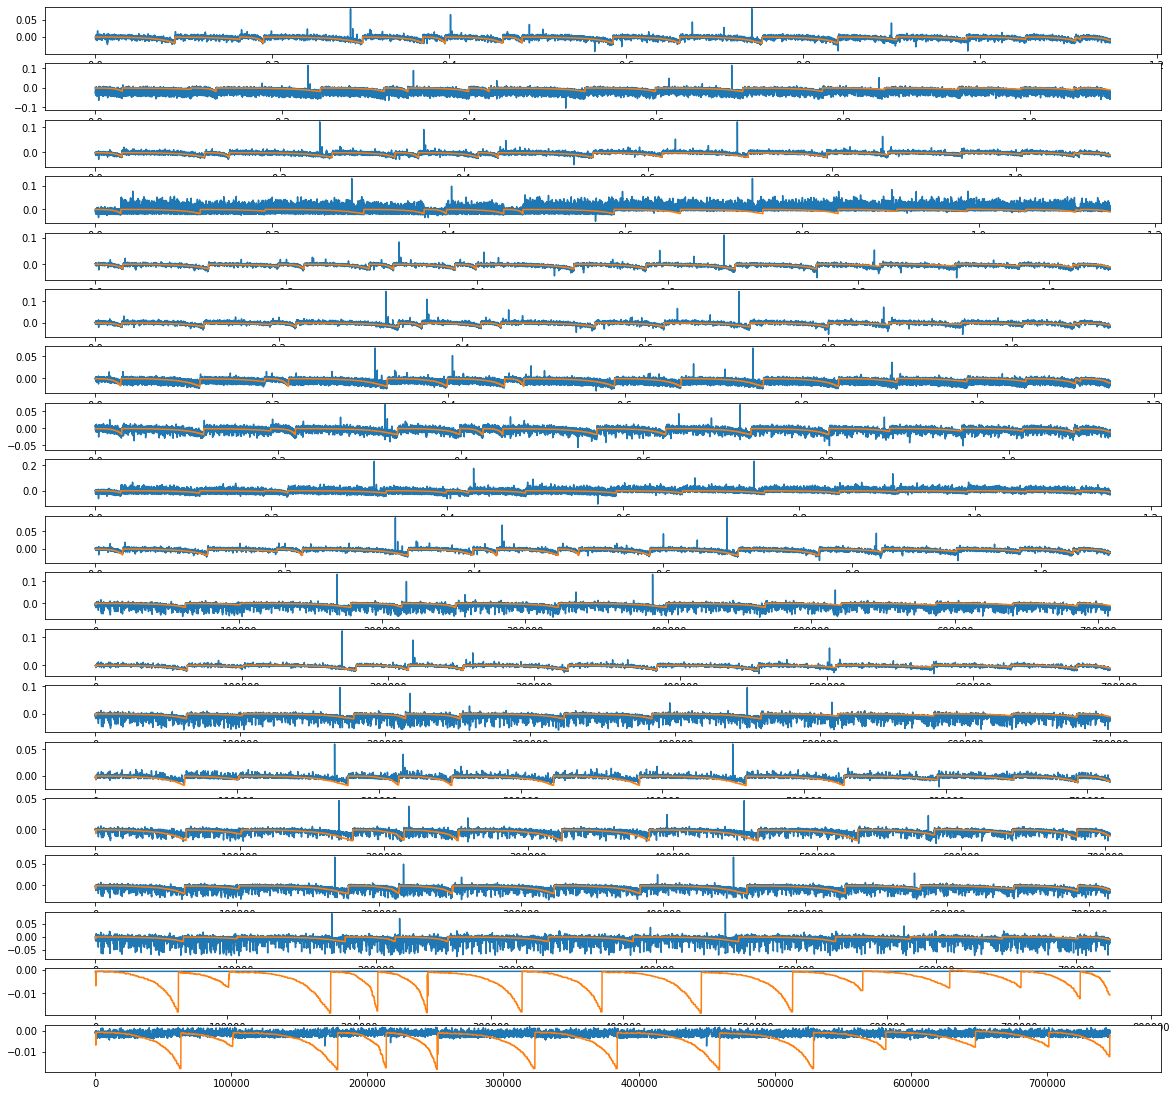

In [31]:
print(df_X_s_sample.shape)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

list_res = []
plt.figure(figsize=(20, 30))
for idu, utrain in enumerate(list_units_filtered):
    df_X_s_sample = df_X_s.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_W_sample = df_W.loc[(df_A.unit == utrain)].reset_index(drop=True)
    alt_limit = (1.5 * np.min(df_W_sample['alt']))
    df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit) ]
    X = df_X_s_sample.loc[0::10000, ['T48', 'Ps30', 'Nf', 'Nc', 'Wf']]
    df_T_sample = df_T.loc[(df_A.unit == utrain)].reset_index(drop=True)
    df_T_sample = df_T_sample.loc[(df_W_sample['alt'] > alt_limit )]
    gt = df_T_sample.loc[0::10000, ["HPT_eff_mod"]]
    Indicator2Eff = LinearRegression()
    Indicator2Eff.fit(X=np.array(X),
                      y=np.array(gt).flatten())
    
    all_res = []
    all_gt = []
    for utest in list_units_filtered:
        if utest != utrain:
            df_X_s_sample = df_X_s.loc[(df_A.unit == utest)].reset_index(drop=True)
            df_W_sample = df_W.loc[(df_A.unit == utest)].reset_index(drop=True)
            df_X_s_sample = df_X_s_sample.loc[(df_W_sample['alt'] > alt_limit)]
            df_T_sample = df_T.loc[(df_A.unit == utest)].reset_index(drop=True)
            df_T_sample = df_T_sample.loc[(df_W_sample['alt'] > alt_limit )]        
            X_test = df_X_s_sample.loc[10000:, ['T48', 'Ps30', 'Nf', 'Nc', 'Wf']]
            gt = df_T_sample.loc[10000:, ["HPT_eff_mod"]]
            eff_estim = Indicator2Eff.predict(np.array(X_test))
            all_res.append(eff_estim)
            all_gt.append(np.array(gt).flatten())
    
    plt.subplot(len(df_A.unit.unique()), 1, idu+1)
    plt.plot(np.concatenate(all_res))
    plt.plot(np.concatenate(all_gt))
    print('learn', utrain, 'rmse:', np.sqrt(mean_squared_error(np.concatenate(all_res), np.concatenate(all_gt))))
    list_res.append(np.sqrt(mean_squared_error(np.concatenate(all_res), np.concatenate(all_gt))))
df_resultats['rmse direct'] = list_res

print(df_resultats)
# L'estimation est plus bruitée